In [1]:
import mercury as mr
 
# configure App properties
app = mr.App(title="Static notebook", description="Display static notebook", static_notebook=True)

mercury.App

In [22]:
# Cell 1: Import dependencies and set up environment
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as robjects
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap
import warnings

# Set plot style and ignore warnings
sns.set_context("talk")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Cell 2: Define utility functions for data loading
# Define the path to the data folder
data_path = "sessions"

# Function to read an RDS file
def read_rds(file_path):
    """Read an RDS file using rpy2."""
    readRDS = robjects.r['readRDS']
    return readRDS(file_path)

# Function to load all sessions
def load_all_sessions(data_path="sessions", n_sessions=18):
    """Load all session data from RDS files."""
    all_sessions = []
    for i in range(1, n_sessions + 1):
        file_name = f'session{i}.rds'
        file_path = os.path.join(data_path, file_name)
        try:
            session_data = read_rds(file_path)
            all_sessions.append(session_data)
            print(f"Loaded session {i}")
        except Exception as e:
            print(f"Error loading session {i}: {e}")
    
    print(f"Loaded {len(all_sessions)} sessions successfully!")
    return all_sessions

In [3]:
# Cell 3: Load the data
# Load all sessions
all_sessions = load_all_sessions()

# Examine structure of first session to understand the data
session1 = all_sessions[0]
print("Available attributes in session data:")
print(session1.names)

Loaded session 1
Loaded session 2
Loaded session 3
Loaded session 4
Loaded session 5
Loaded session 6
Loaded session 7
Loaded session 8
Loaded session 9
Loaded session 10
Loaded session 11
Loaded session 12
Loaded session 13
Loaded session 14
Loaded session 15
Loaded session 16
Loaded session 17
Loaded session 18
Loaded 18 sessions successfully!
Available attributes in session data:
[1] "contrast_left"  "contrast_right" "feedback_type"  "mouse_name"    
[5] "brain_area"     "date_exp"       "spks"           "time"          



In [4]:
# Cell 4: Define functions for basic data exploration
def analyze_session_structure(session):
    """Extract and print detailed session structure."""
    print("Available session attributes:", session.names)
    print(f"Number of trials: {len(session.rx2('spks'))}")
    print(f"Trial duration (bins): {np.array(session.rx2('spks')[0]).shape[1]}")
    
    # Extract unique contrast combinations
    contrast_left = np.array(session.rx2('contrast_left'))
    contrast_right = np.array(session.rx2('contrast_right'))
    unique_contrasts = np.unique(list(zip(contrast_left, contrast_right)), axis=0)
    print(f"Unique stimuli conditions:\n{unique_contrasts}")
    
    # Feedback distribution (1 = success, -1 = failure)
    feedback = np.array(session.rx2('feedback_type'))
    success_rate = np.mean(feedback == 1)
    print(f"Success rate: {success_rate:.2f}")
    print(f"Feedback distribution: {np.bincount(feedback.astype(int) + 1)}")    
    
    # Brain areas
    brain_areas = np.array(session.rx2('brain_area'))
    unique_areas = np.unique(brain_areas)
    print(f"Brain areas ({len(unique_areas)}):\n{unique_areas}")
    
    # Neuron count per brain area
    area_counts = {}
    for area in unique_areas:
        area_counts[area] = np.sum(brain_areas == area)
    
    print("Neurons per brain area:")
    for area, count in sorted(area_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {area}: {count}")

In [5]:
# Cell 5: Basic exploration of session 1
# Analyze structure of first session
analyze_session_structure(session1)

# Extract spike train matrix for the first trial to understand structure
trial1_spks = np.array(session1.rx2("spks")[0])
print(f"\nShape of spike train matrix for Trial 1: {trial1_spks.shape}")
print(f"This means: {trial1_spks.shape[0]} neurons, {trial1_spks.shape[1]} time bins")

# Extract brain areas
brain_areas = np.array(session1.rx2("brain_area"))
print(f"Number of neurons in Session 1: {len(brain_areas)}")

Available session attributes: [1] "contrast_left"  "contrast_right" "feedback_type"  "mouse_name"    
[5] "brain_area"     "date_exp"       "spks"           "time"          

Number of trials: 114
Trial duration (bins): 40
Unique stimuli conditions:
[[0.   0.  ]
 [0.   0.25]
 [0.   0.5 ]
 [0.   1.  ]
 [0.25 0.  ]
 [0.25 0.25]
 [0.25 0.5 ]
 [0.25 1.  ]
 [0.5  0.  ]
 [0.5  0.25]
 [0.5  0.5 ]
 [0.5  1.  ]
 [1.   0.  ]
 [1.   0.25]
 [1.   0.5 ]
 [1.   1.  ]]
Success rate: 0.61
Feedback distribution: [45  0 69]
Brain areas (8):
['ACA' 'CA3' 'DG' 'LS' 'MOs' 'SUB' 'VISp' 'root']
Neurons per brain area:
  VISp: 178
  LS: 139
  MOs: 113
  ACA: 109
  SUB: 75
  CA3: 68
  DG: 34
  root: 18

Shape of spike train matrix for Trial 1: (734, 40)
This means: 734 neurons, 40 time bins
Number of neurons in Session 1: 734


Trial 1 statistics:
  Shape: (734, 40)
  Total spikes: 1161.0
  Mean activity: 0.0395 spikes per bin per neuron
  Active bins: 3.7% of all neuron-time bins


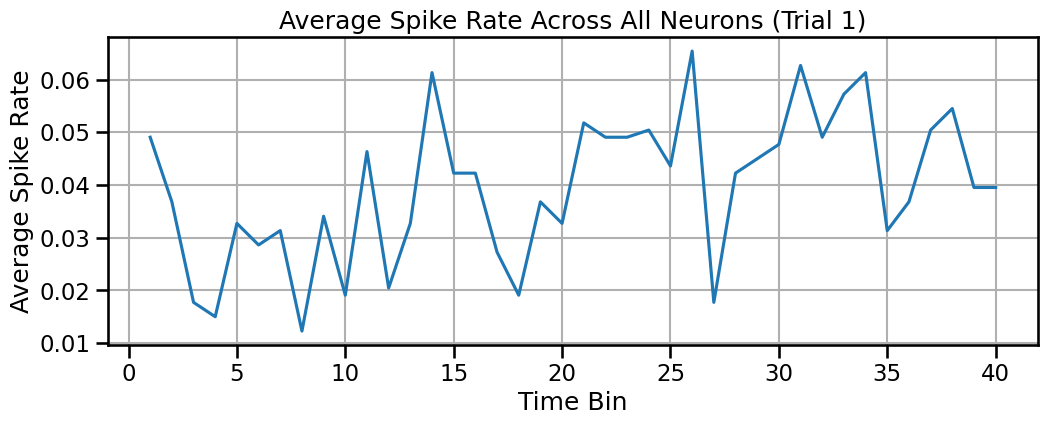

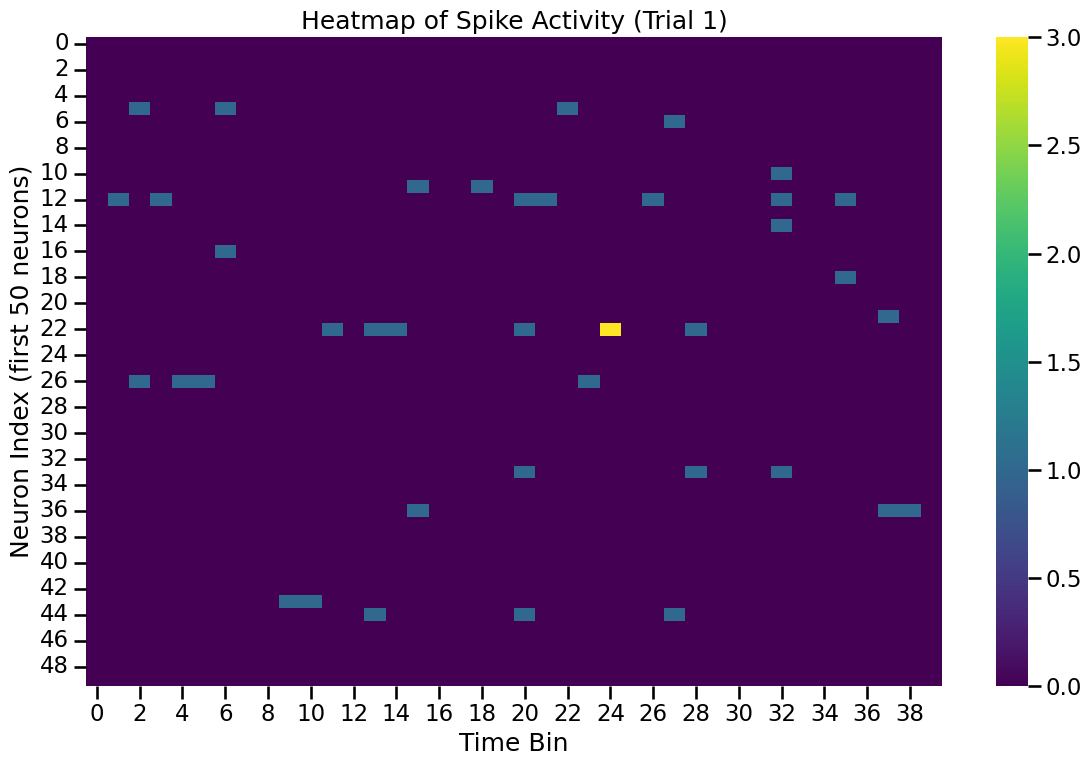


Activity by brain area:
      n_neurons  total_spikes  mean_activity  active_ratio  spikes_per_neuron
DG         34.0          79.0       0.058088      0.050000           2.323529
SUB        75.0         156.0       0.052000      0.050333           2.080000
LS        139.0         269.0       0.048381      0.047842           1.935252
VISp      178.0         300.0       0.042135      0.038062           1.685393
CA3        68.0         104.0       0.038235      0.037132           1.529412
ACA       109.0         138.0       0.031651      0.030046           1.266055
MOs       113.0         106.0       0.023451      0.022566           0.938053
root       18.0           9.0       0.012500      0.012500           0.500000


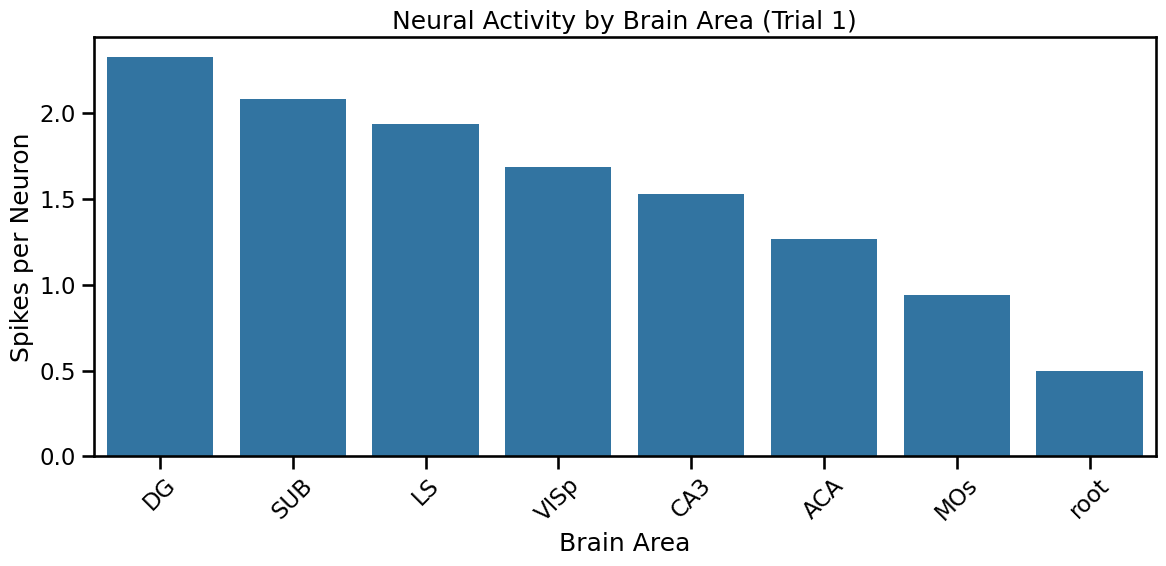

In [6]:
# Cell 6: Explore neural activity in a single trial
def explore_trial_activity(session, trial_id=0):
    """Explore neural activity patterns in a specific trial."""
    spks = np.array(session.rx2('spks')[trial_id])
    brain_areas = np.array(session.rx2('brain_area'))
    
    # Basic statistics
    print(f"Trial {trial_id+1} statistics:")
    print(f"  Shape: {spks.shape}")
    print(f"  Total spikes: {np.sum(spks)}")
    print(f"  Mean activity: {np.mean(spks):.4f} spikes per bin per neuron")
    print(f"  Active bins: {np.mean(spks > 0) * 100:.1f}% of all neuron-time bins")
    
    # Plot average activity across time
    plt.figure(figsize=(12, 4))
    time_avg = np.mean(spks, axis=0)
    plt.plot(range(1, len(time_avg) + 1), time_avg)
    plt.xlabel('Time Bin')
    plt.ylabel('Average Spike Rate')
    plt.title(f'Average Spike Rate Across All Neurons (Trial {trial_id+1})')
    plt.grid(True)
    plt.show()
    
    # Plot heatmap of neural activity
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(spks[:50, :], cmap="viridis", cbar=True)
    plt.xlabel('Time Bin')
    plt.ylabel('Neuron Index (first 50 neurons)')
    plt.title(f'Heatmap of Spike Activity (Trial {trial_id+1})')
    plt.tight_layout()
    plt.show()
    
    # Analyze activity by brain area
    area_activity = {}
    for area in np.unique(brain_areas):
        area_neurons = spks[brain_areas == area]
        if len(area_neurons) > 0:
            area_activity[area] = {
                'n_neurons': len(area_neurons),
                'total_spikes': np.sum(area_neurons),
                'mean_activity': np.mean(area_neurons),
                'active_ratio': np.mean(area_neurons > 0)
            }
    
    # Convert to DataFrame for easier viewing
    area_df = pd.DataFrame(area_activity).T
    area_df['spikes_per_neuron'] = area_df['total_spikes'] / area_df['n_neurons']
    area_df = area_df.sort_values('spikes_per_neuron', ascending=False)
    
    print("\nActivity by brain area:")
    print(area_df)
    
    # Plot activity by brain area
    plt.figure(figsize=(12, 6))
    sns.barplot(x=area_df.index, y='spikes_per_neuron', data=area_df)
    plt.xticks(rotation=45)
    plt.xlabel('Brain Area')
    plt.ylabel('Spikes per Neuron')
    plt.title(f'Neural Activity by Brain Area (Trial {trial_id+1})')
    plt.tight_layout()
    plt.show()
    
    return area_df

# Explore neural activity in the first trial
activity_by_area = explore_trial_activity(session1, trial_id=0)

In [7]:
# Cell 7: Create a function to extract trial-level data
def get_trial_data(session, trial_id):
    """
    Extract neural activity summary for a given trial.
    
    Parameters:
    session: R object containing session data
    trial_id: 0-indexed trial ID
    
    Returns:
    DataFrame with summary statistics per brain area
    """
    spikes = np.array(session.rx2("spks")[trial_id])  # Shape: (n_neurons, n_time_bins)
    neuron_spike = np.sum(spikes, axis=1)  # Sum of spikes over time bins for each neuron
    brain_area = np.array(session.rx2("brain_area"))  # Brain area for each neuron
    
    df = pd.DataFrame({
        "neuron_spike": neuron_spike,
        "brain_area": brain_area
    })
    
    # Group by brain area and compute summary statistics
    trial_df = (df.groupby("brain_area")
                .agg(region_sum_spike=("neuron_spike", "sum"),
                     region_count=("neuron_spike", "count"),
                     region_mean_spike=("neuron_spike", "mean"))
                .reset_index())

    # Add trial metadata
    trial_df["trial_id"] = trial_id + 1  # 1-based indexing for readability
    trial_df["contrast_left"] = session.rx2("contrast_left")[trial_id]
    trial_df["contrast_right"] = session.rx2("contrast_right")[trial_id]
    trial_df["feedback_type"] = session.rx2("feedback_type")[trial_id]
    trial_df["contrast_diff"] = abs(trial_df["contrast_left"] - trial_df["contrast_right"])
    
    return trial_df

# Example: Get data for a specific trial
trial_summary = get_trial_data(session1, trial_id=0)
print("Trial summary by brain area:")
print(trial_summary)

Trial summary by brain area:
  brain_area  region_sum_spike  region_count  region_mean_spike  trial_id  \
0        ACA             138.0           109           1.266055         1   
1        CA3             104.0            68           1.529412         1   
2         DG              79.0            34           2.323529         1   
3         LS             269.0           139           1.935252         1   
4        MOs             106.0           113           0.938053         1   
5        SUB             156.0            75           2.080000         1   
6       VISp             300.0           178           1.685393         1   
7       root               9.0            18           0.500000         1   

   contrast_left  contrast_right  feedback_type  contrast_diff  
0            0.0             0.5            1.0            0.5  
1            0.0             0.5            1.0            0.5  
2            0.0             0.5            1.0            0.5  
3            0.0 

In [8]:
# Cell 8: Analyze neural activity across time bins
def get_trial_bin_average(session):
    """
    Compute the average spike rate per time bin for each trial in a session.
    
    Parameters:
    session: R object containing session data
    
    Returns:
    DataFrame with average activity per time bin for each trial, plus metadata
    """
    spks = session.rx2('spks')
    trial_avgs = []
    n_trials = len(spks)
    n_bins = np.array(spks[0]).shape[1]  # Assuming all trials have the same number of time bins

    for trial_id in range(n_trials):
        trial_matrix = np.array(spks[trial_id])  # (n_neurons, n_bins)
        bin_avg = np.mean(trial_matrix, axis=0)  # Average across neurons for each time bin
        trial_avgs.append(bin_avg)

    bin_columns = [f"bin{i+1}" for i in range(n_bins)]
    df = pd.DataFrame(trial_avgs, columns=bin_columns)

    # Add trial metadata
    df["trial_id"] = np.arange(1, n_trials + 1)
    df["contrast_left"] = np.array(session.rx2("contrast_left"))
    df["contrast_right"] = np.array(session.rx2("contrast_right"))
    df["feedback_type"] = np.array(session.rx2("feedback_type"))
    df["contrast_diff"] = np.abs(df["contrast_left"] - df["contrast_right"])
    
    return df

# Get time bin data for session 1
trial_bin_avg_df = get_trial_bin_average(session1)
print("Average neural activity by time bin (first 5 trials):")
print(trial_bin_avg_df.head())

Average neural activity by time bin (first 5 trials):
       bin1      bin2      bin3      bin4      bin5      bin6      bin7  \
0  0.049046  0.036785  0.017711  0.014986  0.032698  0.028610  0.031335   
1  0.029973  0.031335  0.034060  0.027248  0.025886  0.031335  0.021798   
2  0.049046  0.050409  0.029973  0.043597  0.024523  0.040872  0.029973   
3  0.055858  0.053134  0.027248  0.061308  0.057221  0.059946  0.044959   
4  0.027248  0.043597  0.031335  0.024523  0.044959  0.038147  0.046322   

       bin8      bin9     bin10  ...     bin36     bin37     bin38     bin39  \
0  0.012262  0.034060  0.019074  ...  0.036785  0.050409  0.054496  0.039510   
1  0.023161  0.023161  0.034060  ...  0.053134  0.061308  0.038147  0.028610   
2  0.038147  0.034060  0.042234  ...  0.042234  0.035422  0.027248  0.038147   
3  0.028610  0.039510  0.035422  ...  0.038147  0.027248  0.034060  0.038147   
4  0.057221  0.047684  0.016349  ...  0.047684  0.035422  0.028610  0.028610   

      bin40  t

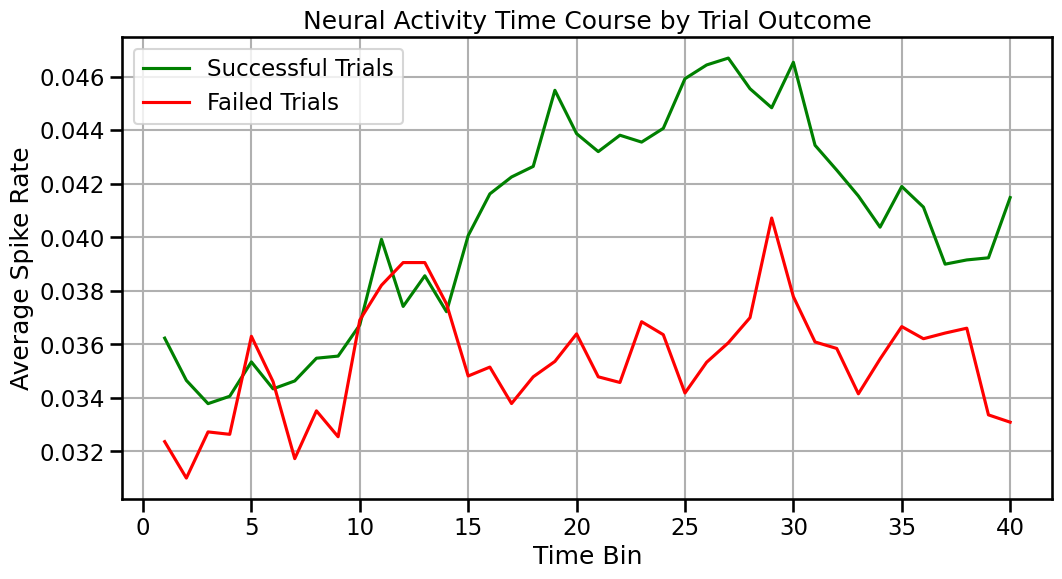

In [9]:
# Cell 9: Visualize time-resolved neural activity for different trial outcomes
# Separate successful and failed trials
success_trials = trial_bin_avg_df[trial_bin_avg_df['feedback_type'] == 1]
failure_trials = trial_bin_avg_df[trial_bin_avg_df['feedback_type'] == -1]

# Calculate mean activity across trials for each time bin
time_bins = [col for col in trial_bin_avg_df.columns if col.startswith('bin')]
success_time_avg = success_trials[time_bins].mean()
failure_time_avg = failure_trials[time_bins].mean()

# Plot time course for successful vs. failed trials
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(time_bins) + 1), success_time_avg, 'g-', label='Successful Trials')
plt.plot(range(1, len(time_bins) + 1), failure_time_avg, 'r-', label='Failed Trials')
plt.xlabel('Time Bin')
plt.ylabel('Average Spike Rate')
plt.title('Neural Activity Time Course by Trial Outcome')
plt.legend()
plt.grid(True)
plt.show()

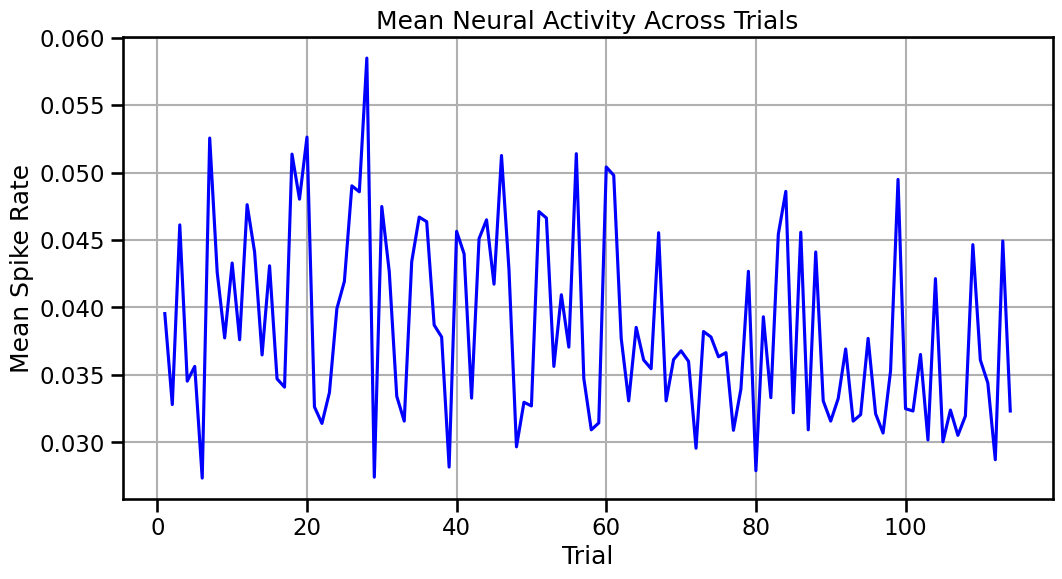

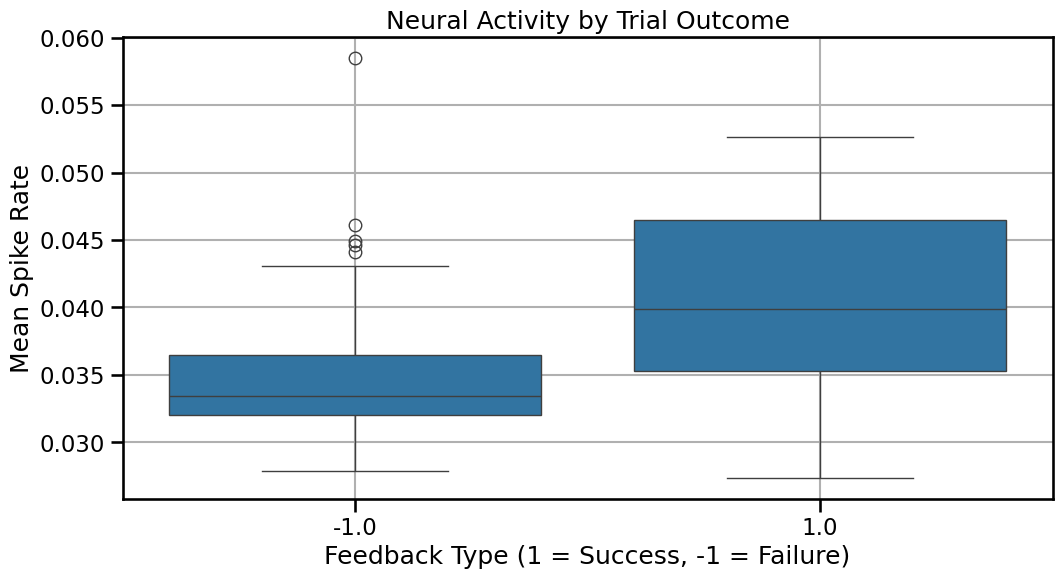

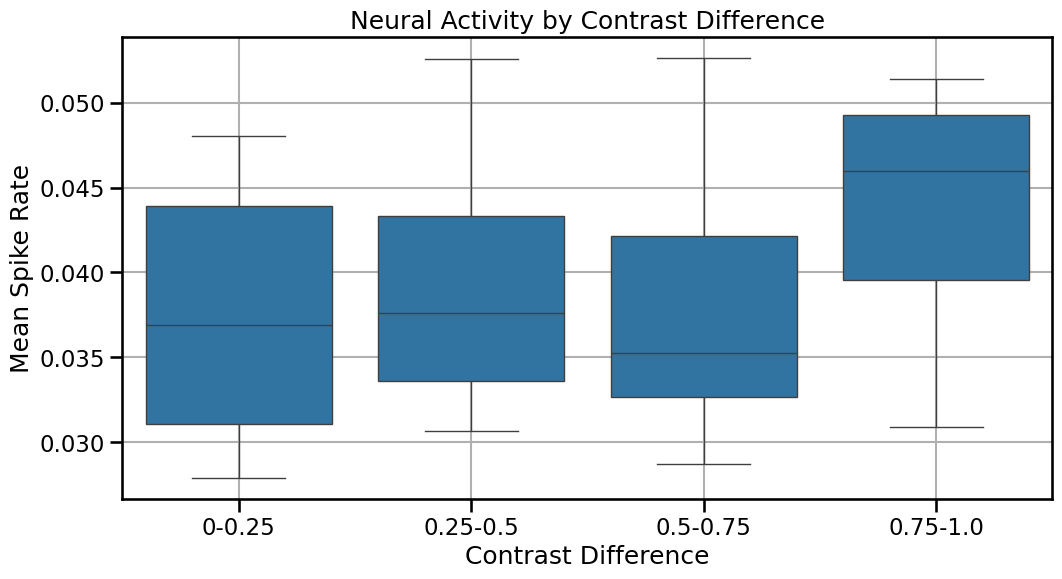

In [10]:
# Cell 10: Create a function to analyze trial progression
def analyze_trial_progression(session):
    """Analyze how neural activity changes across trials in a session."""
    n_trials = len(session.rx2('spks'))
    trial_metrics = []
    
    for i in range(n_trials):
        spks = np.array(session.rx2('spks')[i])
        trial_metrics.append({
            'trial_id': i+1,
            'mean_activity': np.mean(spks),
            'peak_activity': np.max(np.mean(spks, axis=0)),
            'contrast_left': session.rx2('contrast_left')[i],
            'contrast_right': session.rx2('contrast_right')[i],
            'contrast_diff': abs(session.rx2('contrast_left')[i] - session.rx2('contrast_right')[i]),
            'feedback': session.rx2('feedback_type')[i]
        })
    
    trial_df = pd.DataFrame(trial_metrics)
    
    # Plot activity over trials
    plt.figure(figsize=(12, 6))
    plt.plot(trial_df['trial_id'], trial_df['mean_activity'], 'b-')
    plt.xlabel('Trial')
    plt.ylabel('Mean Spike Rate')
    plt.title('Mean Neural Activity Across Trials')
    plt.grid(True)
    plt.show()
    
    # Plot activity by trial outcome
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='feedback', y='mean_activity', data=trial_df)
    plt.xlabel('Feedback Type (1 = Success, -1 = Failure)')
    plt.ylabel('Mean Spike Rate')
    plt.title('Neural Activity by Trial Outcome')
    plt.grid(True)
    plt.show()
    
    # Plot activity by contrast difference
    trial_df['contrast_diff_binned'] = pd.cut(trial_df['contrast_diff'], 
                                            bins=[0, 0.25, 0.5, 0.75, 1.0],
                                            labels=['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1.0'])
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='contrast_diff_binned', y='mean_activity', data=trial_df)
    plt.xlabel('Contrast Difference')
    plt.ylabel('Mean Spike Rate')
    plt.title('Neural Activity by Contrast Difference')
    plt.grid(True)
    plt.show()
    
    return trial_df

# Analyze trial progression in session 1
trial_progression = analyze_trial_progression(session1)

In [11]:
# Cell 11: Define function to compute session-level summary statistics
def get_session_summary(all_sessions):
    """
    Compute summary statistics for each session.
    
    Parameters:
    all_sessions: List of R objects containing session data
    
    Returns:
    DataFrame with session-level summary statistics
    """
    session_summaries = []

    for session_id, session in enumerate(all_sessions, start=1):
        spks = session.rx2("spks")
        brain_areas = np.array(session.rx2("brain_area"))
        feedback = np.array(session.rx2("feedback_type"))
        n_neurons = len(brain_areas)
        n_brain_areas = len(np.unique(brain_areas))
        n_trials = len(spks)

        # Get mouse name and experiment date
        mouse_name = session.rx2('mouse_name')[0]
        date_exp = session.rx2('date_exp')[0]
        
        # Compute mean session spike rate
        mean_spike_rate = np.mean([np.sum(np.array(trial)) / np.array(trial).size for trial in spks])

        # Compute success rate
        success_rate = np.mean(feedback == 1)
        
        # Compute contrast statistics
        contrast_left = np.array(session.rx2("contrast_left"))
        contrast_right = np.array(session.rx2("contrast_right"))
        contrast_diff = np.abs(contrast_left - contrast_right)
        mean_contrast_diff = np.mean(contrast_diff)

        session_summaries.append({
            "session_id": session_id,
            "mouse_name": mouse_name,
            "date_exp": date_exp,
            "n_neurons": n_neurons,
            "n_brain_areas": n_brain_areas,
            "n_trials": n_trials,
            "mean_spike_rate": mean_spike_rate,
            "success_rate": success_rate,
            "mean_contrast_diff": mean_contrast_diff
        })

    return pd.DataFrame(session_summaries)

# Compute session summaries
session_summary_df = get_session_summary(all_sessions)
print("Session summary statistics:")
print(session_summary_df)

Session summary statistics:
    session_id mouse_name    date_exp  n_neurons  n_brain_areas  n_trials  \
0            1       Cori  2016-12-14        734              8       114   
1            2       Cori  2016-12-17       1070              5       251   
2            3       Cori  2016-12-18        619             11       228   
3            4  Forssmann  2017-11-01       1769             11       249   
4            5  Forssmann  2017-11-02       1077             10       254   
5            6  Forssmann  2017-11-04       1169              5       290   
6            7  Forssmann  2017-11-05        584              8       252   
7            8      Hench  2017-06-15       1157             15       250   
8            9      Hench  2017-06-16        788             12       372   
9           10      Hench  2017-06-17       1172             13       447   
10          11      Hench  2017-06-18        857              6       342   
11          12  Lederberg  2017-12-05        698

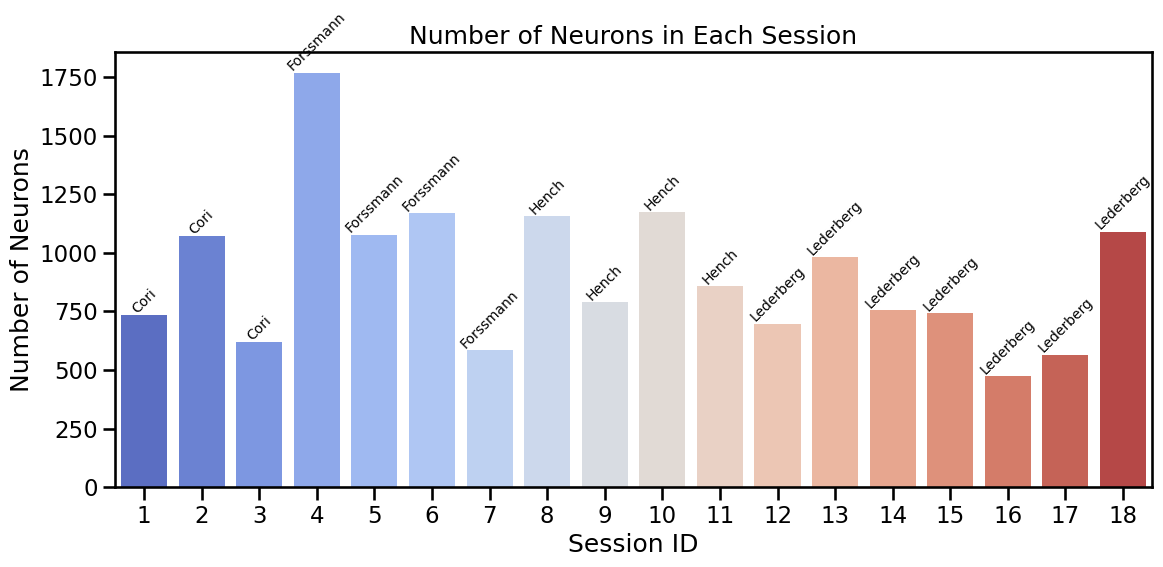

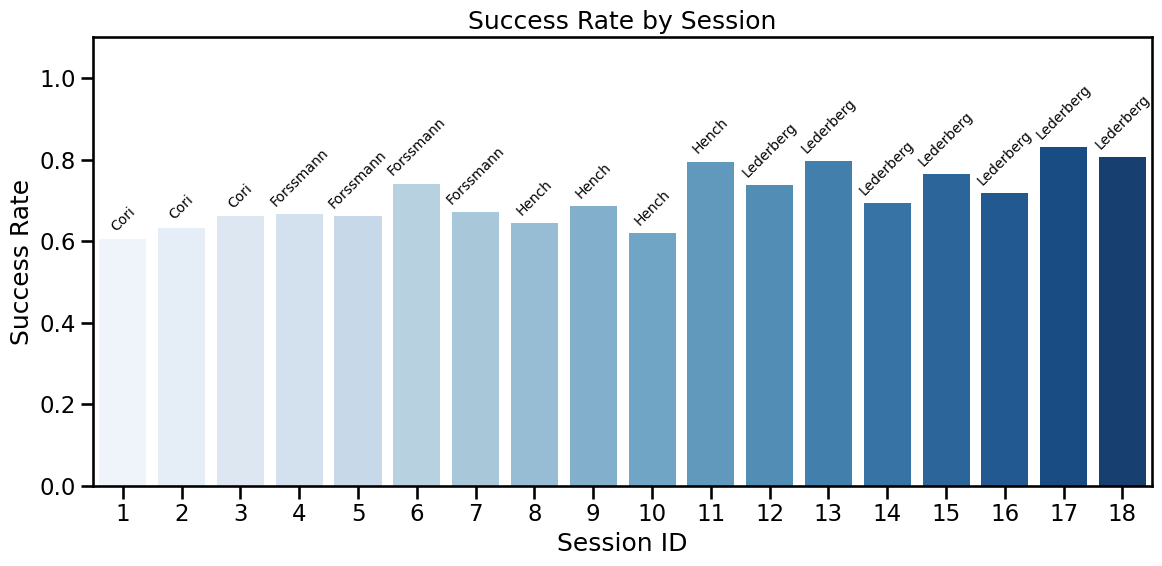

In [12]:
# Cell 12: Visualize session-level statistics
# Plot number of neurons by session
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="session_id", y="n_neurons", data=session_summary_df, palette="coolwarm")
plt.xlabel("Session ID")
plt.ylabel("Number of Neurons")
plt.title("Number of Neurons in Each Session")
# Add mouse name labels
for i, row in session_summary_df.iterrows():
    ax.text(i, row['n_neurons'] + 10, row['mouse_name'], ha='center', rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

# Plot success rate by session
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="session_id", y="success_rate", data=session_summary_df, palette="Blues")
plt.xlabel("Session ID")
plt.ylabel("Success Rate")
plt.title("Success Rate by Session")
# Add mouse name labels
for i, row in session_summary_df.iterrows():
    ax.text(i, row['success_rate'] + 0.02, row['mouse_name'], ha='center', rotation=45, fontsize=10)
plt.ylim(0, 1.1)  
plt.tight_layout()
plt.show()

Number of NaN values in contrast_diff: 0
Total entries: 5081


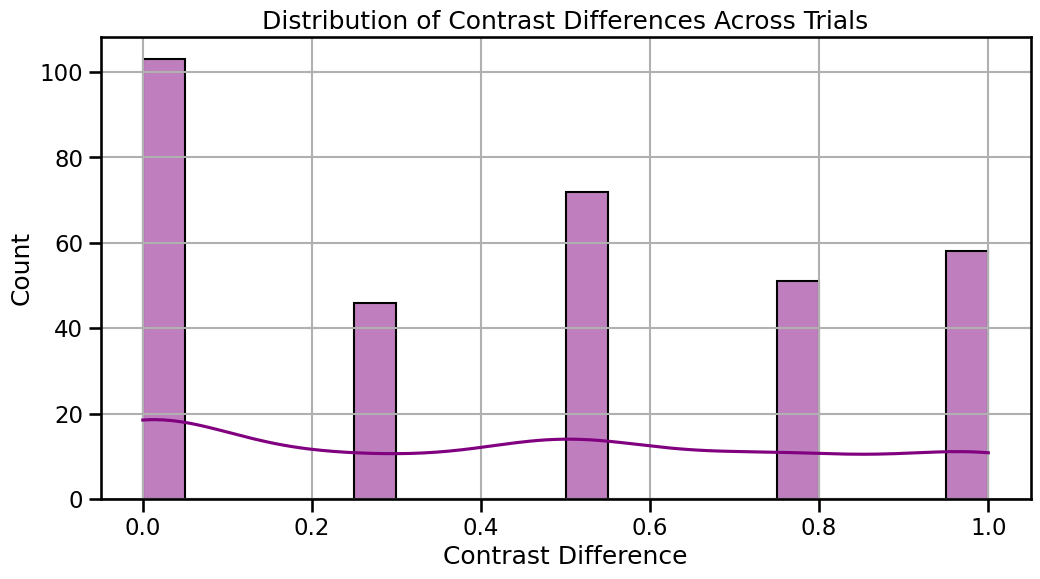

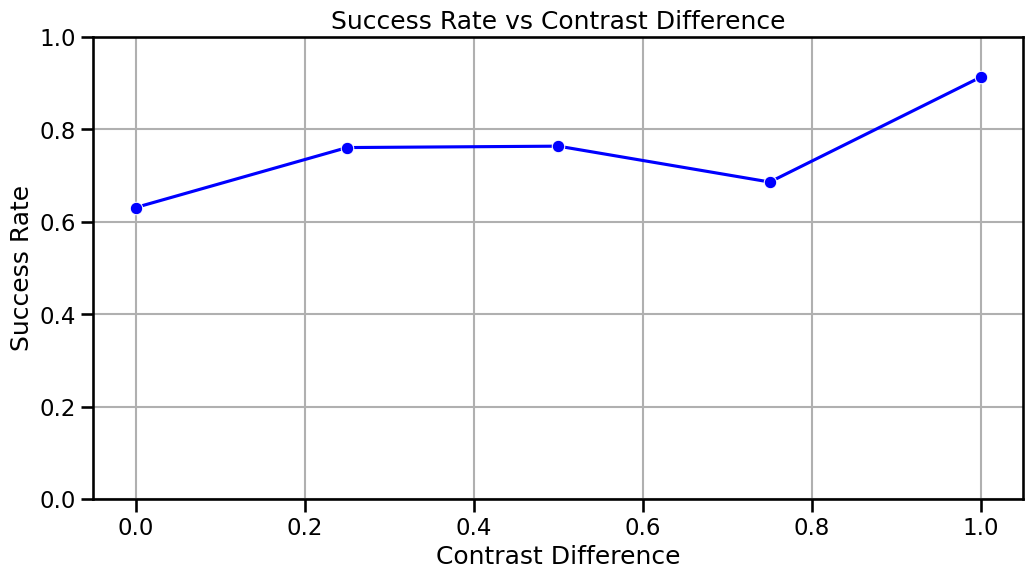

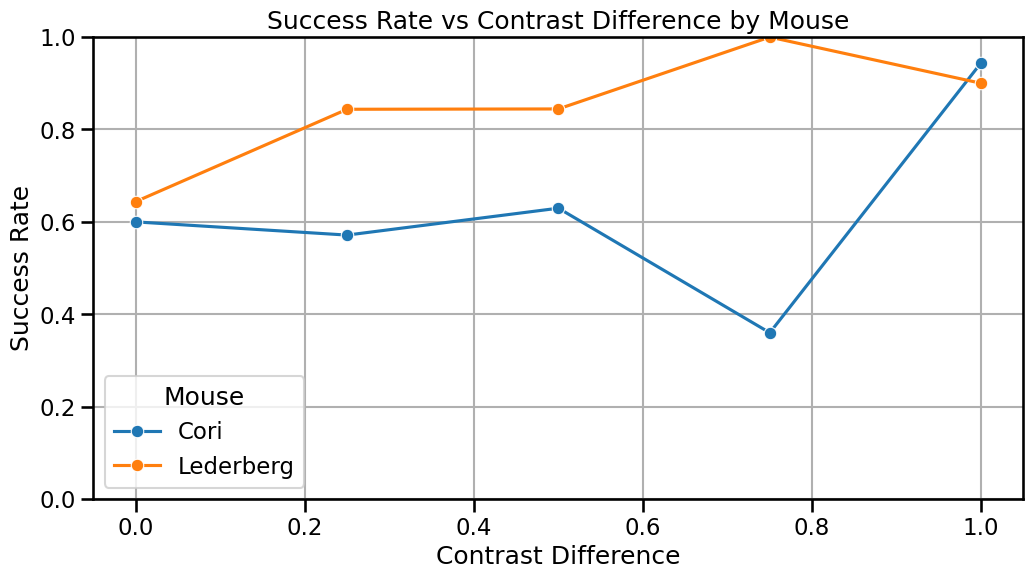

In [13]:
# Cell 13: Analyze success rates by contrast difference
def analyze_contrast_success(all_sessions):
    """Analyze how contrast differences affect success rates across all sessions."""
    contrast_data = []

    for session_id, session in enumerate(all_sessions, start=1):
        contrast_left = np.array(session.rx2("contrast_left"))
        contrast_right = np.array(session.rx2("contrast_right"))
        feedback = np.array(session.rx2("feedback_type"))
        mouse_name = session.rx2("mouse_name")[0]

        contrast_diff = np.abs(contrast_left - contrast_right)

        for i in range(len(contrast_diff)):
            contrast_data.append({
                "session_id": session_id,
                "mouse_name": mouse_name,
                "contrast_left": contrast_left[i],
                "contrast_right": contrast_right[i],
                "contrast_diff": contrast_diff[i],
                "success": 1 if feedback[i] == 1 else 0  # Convert feedback to binary
            })

    contrast_df = pd.DataFrame(contrast_data)
    
    # Check for missing values
    print(f"Number of NaN values in contrast_diff: {contrast_df['contrast_diff'].isna().sum()}")
    print(f"Total entries: {len(contrast_df)}")
    
    # Ensure correct data type
    contrast_df["contrast_diff"] = pd.to_numeric(contrast_df["contrast_diff"], errors="coerce")
    
    # Group by contrast difference and compute success rate
    grouped_data = contrast_df.groupby('contrast_diff')['success'].agg(['mean', 'count']).reset_index()
    grouped_data.columns = ['contrast_diff', 'success_rate', 'trial_count']
    grouped_data = grouped_data.sort_values('contrast_diff')
    
    # Plot distribution of contrast differences
    plt.figure(figsize=(12, 6))
    sns.histplot(contrast_df["contrast_diff"], bins=20, kde=True, color="purple")
    plt.xlabel("Contrast Difference")
    plt.ylabel("Count")
    plt.title("Distribution of Contrast Differences Across Trials")
    plt.grid(True)
    plt.show()
    
    # Plot success rate vs contrast difference
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="contrast_diff", y="success_rate", data=grouped_data, marker="o", color="blue")
    plt.xlabel("Contrast Difference")
    plt.ylabel("Success Rate")
    plt.title("Success Rate vs Contrast Difference")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()
    
    # Group by mouse and contrast difference
    mouse_contrast = contrast_df.groupby(['mouse_name', 'contrast_diff'])['success'].mean().reset_index()
    mouse_contrast.columns = ['mouse_name', 'contrast_diff', 'success_rate']
    
    # Plot success rate by mouse and contrast difference
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="contrast_diff", y="success_rate", hue="mouse_name", data=mouse_contrast, marker="o")
    plt.xlabel("Contrast Difference")
    plt.ylabel("Success Rate")
    plt.title("Success Rate vs Contrast Difference by Mouse")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(title="Mouse")
    plt.show()
    
    return contrast_df

# Analyze contrast-success relationship
contrast_df = analyze_contrast_success(all_sessions)

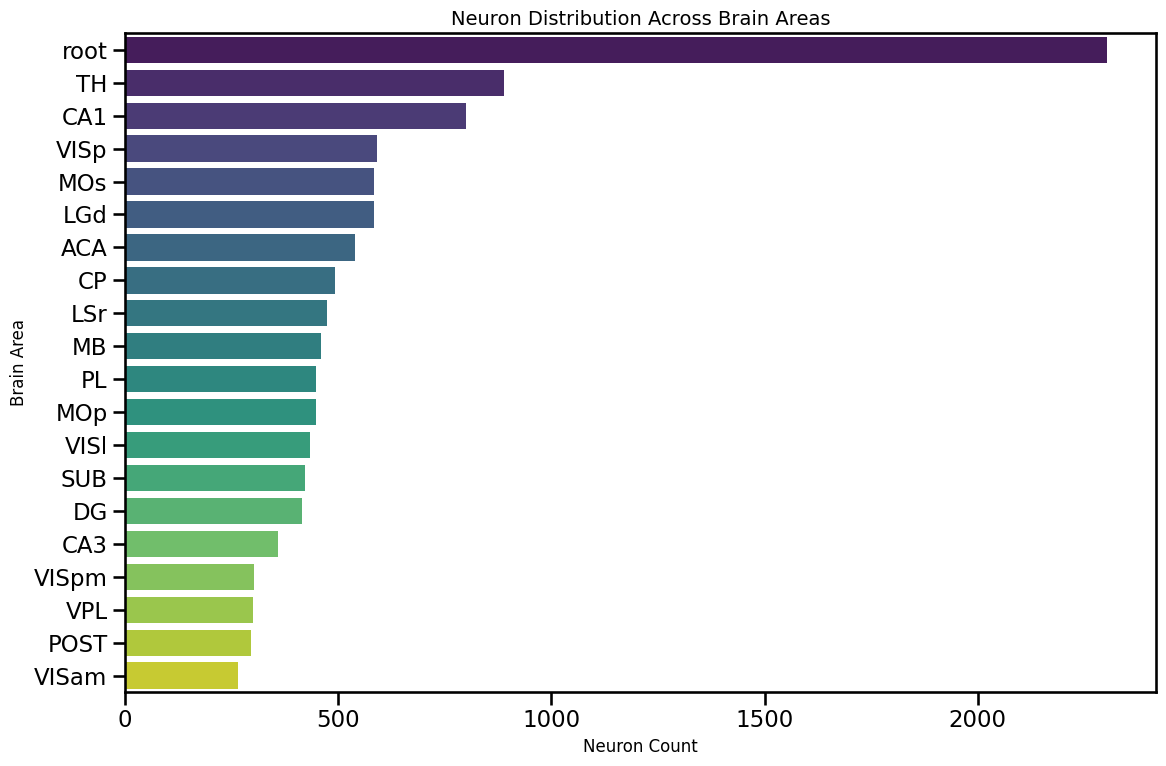

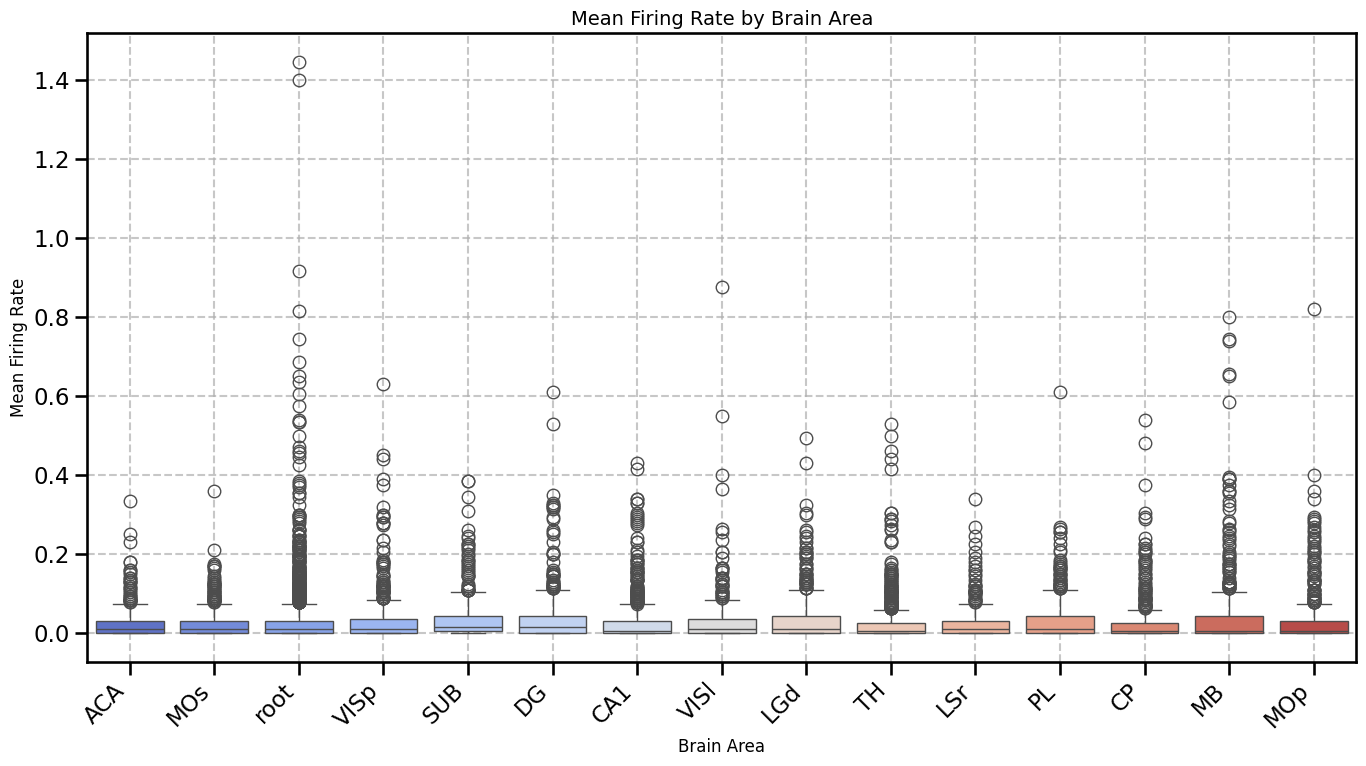

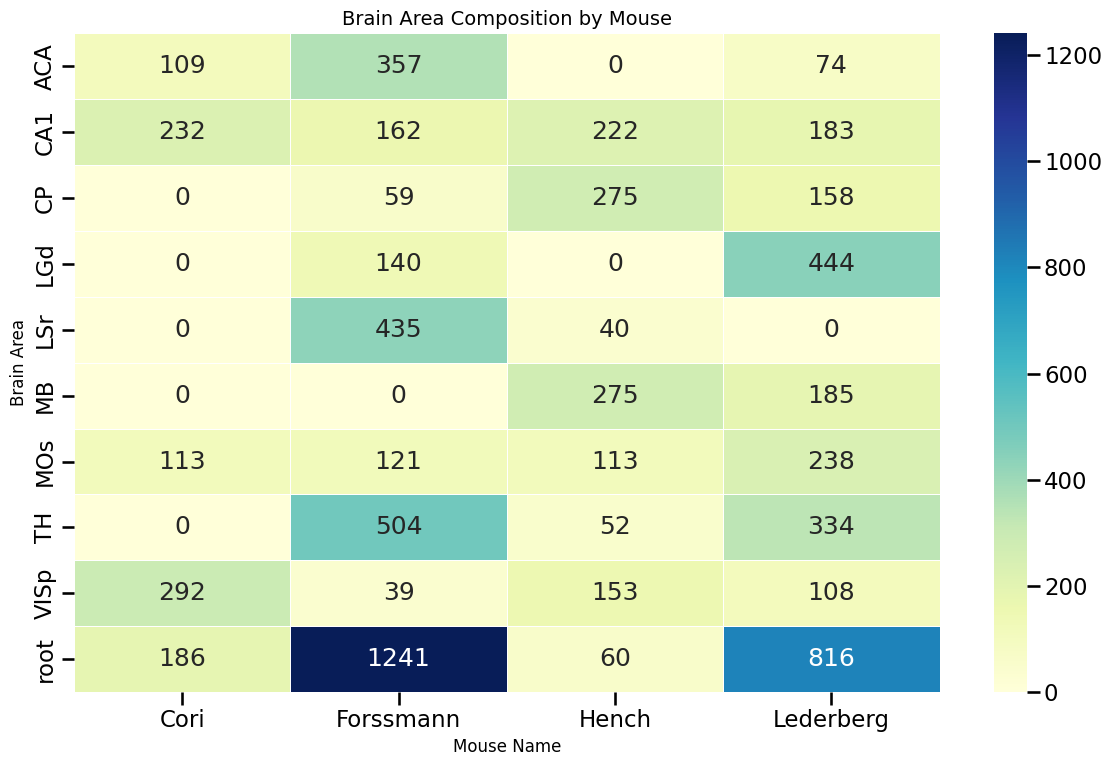

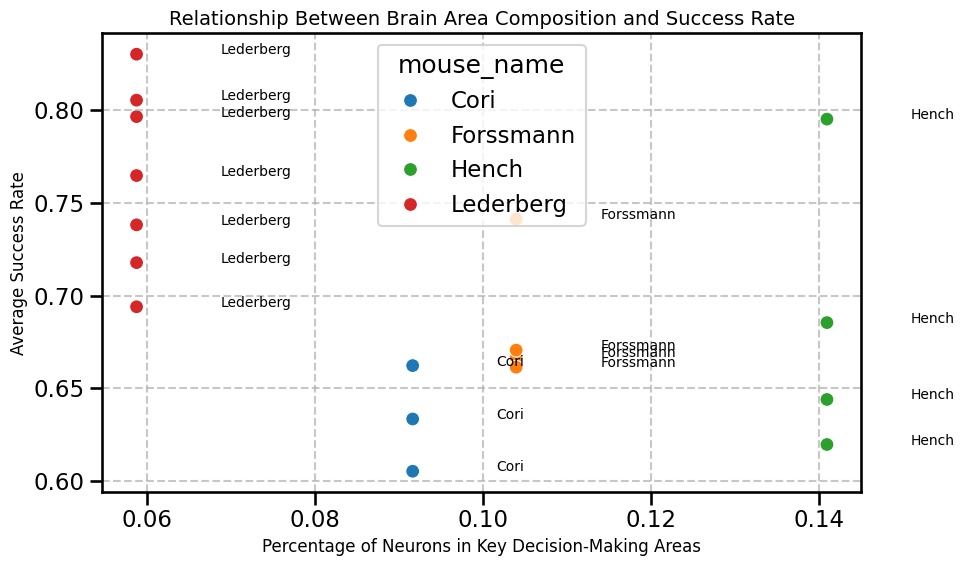

In [14]:
# Cell 14: Compare brain areas across sessions and mice with clearer visualizations
def compare_brain_areas_improved(all_sessions):
    """
    Compare brain area distribution and activity across sessions and mice with
    improved visualizations inspired by your classmate's approach.
    """
    # Initialize data collection
    brain_area_data = []
    
    # Process each session
    for session_id, session in enumerate(all_sessions, start=1):
        brain_areas = np.array(session.rx2("brain_area"))
        mouse_name = session.rx2("mouse_name")[0]
        date_exp = session.rx2("date_exp")[0]
        
        # Extract the spike data from a sample trial to calculate mean firing rates
        spks = session.rx2('spks')
        sample_trial = np.array(spks[0])  # First trial
        
        # Calculate mean firing rate for each neuron
        mean_firing_rates = []
        for trial_idx in range(min(5, len(spks))):  # Use first 5 trials for averaging
            trial_spks = np.array(spks[trial_idx])
            if trial_idx == 0:
                mean_firing_rates = np.mean(trial_spks, axis=1)
            else:
                mean_firing_rates += np.mean(trial_spks, axis=1)
                
        mean_firing_rates = mean_firing_rates / min(5, len(spks))
        
        # Store data for each neuron
        for i, area in enumerate(brain_areas):
            brain_area_data.append({
                'session_id': session_id,
                'mouse_name': mouse_name,
                'date_exp': date_exp,
                'brain_area': area,
                'mean_firing_rate': mean_firing_rates[i] if i < len(mean_firing_rates) else np.nan
            })
    
    # Convert to DataFrame
    brain_df = pd.DataFrame(brain_area_data)
    
    # Plot 1: Neuron distribution across brain areas (bar chart)
    plt.figure(figsize=(12, 8))
    area_counts = brain_df["brain_area"].value_counts()
    
    # Plot only top 20 areas for readability
    top_areas = area_counts.head(20)
    sns.barplot(x=top_areas.values, y=top_areas.index, palette="viridis")
    
    plt.title("Neuron Distribution Across Brain Areas", fontsize=14)
    plt.xlabel("Neuron Count", fontsize=12)
    plt.ylabel("Brain Area", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Mean firing rate by brain area (box plot)
    plt.figure(figsize=(14, 8))
    
    # Get top 15 areas by neuron count for the box plot
    top_areas = area_counts.head(15).index.tolist()
    brain_subset = brain_df[brain_df['brain_area'].isin(top_areas)]
    
    # Create box plot
    sns.boxplot(x="brain_area", y="mean_firing_rate", data=brain_subset, palette="coolwarm")
    plt.xticks(rotation=45, ha='right')
    plt.title("Mean Firing Rate by Brain Area", fontsize=14)
    plt.xlabel("Brain Area", fontsize=12)
    plt.ylabel("Mean Firing Rate", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Brain area composition by mouse
    plt.figure(figsize=(12, 8))
    
    # Count neurons by mouse and brain area
    mouse_area_counts = brain_df.groupby(['mouse_name', 'brain_area']).size().reset_index(name='count')
    
    # Get most common brain areas across all mice
    common_areas = area_counts.head(10).index.tolist()
    mouse_area_subset = mouse_area_counts[mouse_area_counts['brain_area'].isin(common_areas)]
    
    # Create a pivot table for the heatmap
    heatmap_data = mouse_area_subset.pivot(index="brain_area", columns="mouse_name", values="count").fillna(0)
    
    # Create heatmap
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=.5)
    plt.title("Brain Area Composition by Mouse", fontsize=14)
    plt.xlabel("Mouse Name", fontsize=12)
    plt.ylabel("Brain Area", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Success rate by brain area presence
    # Get success rates from session_summary_df
    success_by_mouse = session_summary_df[['mouse_name', 'success_rate']].copy()
    
    # Calculate average number of neurons in key brain areas per mouse
    key_brain_areas = ['MOs', 'MOp', 'ACA', 'SS', 'VIS']  # Important for decision making
    area_presence = {}
    
    for mouse in success_by_mouse['mouse_name'].unique():
        mouse_sessions = brain_df[brain_df['mouse_name'] == mouse]
        area_counts = mouse_sessions['brain_area'].value_counts()
        
        # Calculate percentage of neurons in key areas
        total_neurons = len(mouse_sessions)
        key_area_neurons = sum(area_counts.get(area, 0) for area in key_brain_areas)
        area_presence[mouse] = key_area_neurons / total_neurons if total_neurons > 0 else 0
    
    # Add to DataFrame
    success_by_mouse['key_area_percentage'] = success_by_mouse['mouse_name'].map(area_presence)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='key_area_percentage', y='success_rate', data=success_by_mouse, 
                   s=100, hue='mouse_name')
    
    # Add labels for each point
    for idx, row in success_by_mouse.iterrows():
        plt.text(row['key_area_percentage'] + 0.01, row['success_rate'], 
                row['mouse_name'], fontsize=10)
    
    plt.title("Relationship Between Brain Area Composition and Success Rate", fontsize=14)
    plt.xlabel("Percentage of Neurons in Key Decision-Making Areas", fontsize=12)
    plt.ylabel("Average Success Rate", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return brain_df

# Compare brain areas across sessions with improved visualizations
brain_area_df = compare_brain_areas_improved(all_sessions)

Analyzing activity in brain area: VISp
Number of neurons in VISp: 178


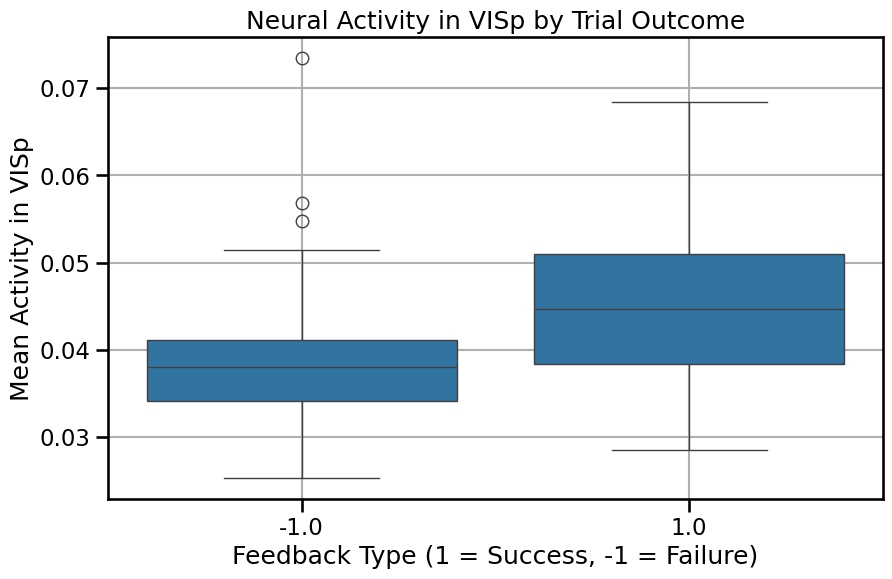

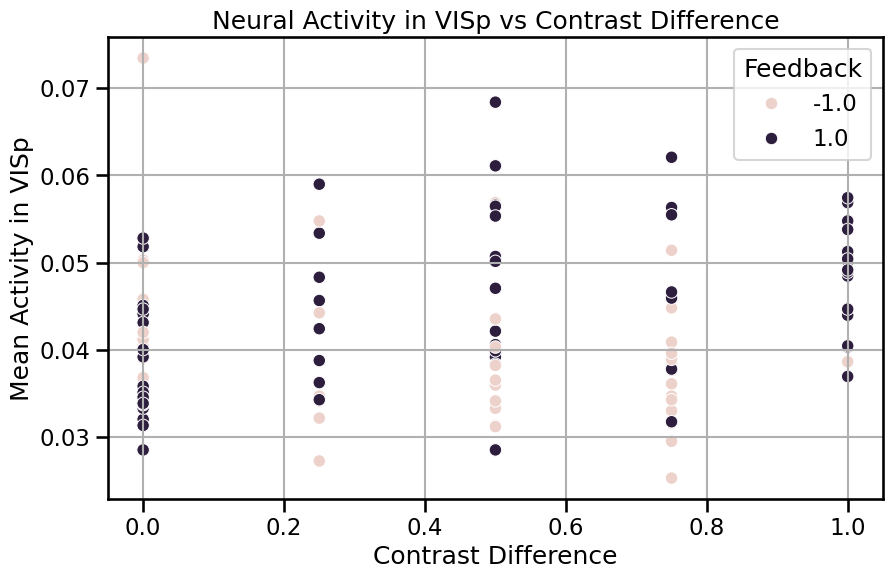

In [15]:
# Cell 15: Create a function to analyze trial-level activity by brain area
def analyze_area_activity(session, area_of_interest=None):
    """
    Analyze activity patterns by brain area within a session.
    
    Parameters:
    session: R object containing session data
    area_of_interest: Optional specific brain area to focus on
    
    Returns:
    DataFrame with area-specific activity metrics
    """
    n_trials = len(session.rx2('spks'))
    brain_areas = np.array(session.rx2('brain_area'))
    unique_areas = np.unique(brain_areas)
    
    # If no specific area provided, use the one with most neurons
    if area_of_interest is None:
        area_counts = {area: np.sum(brain_areas == area) for area in unique_areas}
        area_of_interest = max(area_counts, key=area_counts.get)
    
    print(f"Analyzing activity in brain area: {area_of_interest}")
    
    # Get neurons in the area of interest
    area_neurons_idx = np.where(brain_areas == area_of_interest)[0]
    n_area_neurons = len(area_neurons_idx)
    print(f"Number of neurons in {area_of_interest}: {n_area_neurons}")
    
    # Extract activity for each trial
    trial_activity = []
    for trial_id in range(n_trials):
        spks = np.array(session.rx2('spks')[trial_id])
        area_spks = spks[area_neurons_idx, :]
        
        # Compute area metrics
        trial_activity.append({
            'trial_id': trial_id + 1,
            'area': area_of_interest,
            'mean_activity': np.mean(area_spks),
            'peak_activity': np.max(np.mean(area_spks, axis=0)),  # Peak of time-averaged activity
            'active_ratio': np.mean(area_spks > 0),
            'contrast_left': session.rx2('contrast_left')[trial_id],
            'contrast_right': session.rx2('contrast_right')[trial_id],
            'contrast_diff': abs(session.rx2('contrast_left')[trial_id] - session.rx2('contrast_right')[trial_id]),
            'feedback': session.rx2('feedback_type')[trial_id]
        })
    
    activity_df = pd.DataFrame(trial_activity)
    
    # Plot activity by trial outcome
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='feedback', y='mean_activity', data=activity_df)
    plt.xlabel('Feedback Type (1 = Success, -1 = Failure)')
    plt.ylabel(f'Mean Activity in {area_of_interest}')
    plt.title(f'Neural Activity in {area_of_interest} by Trial Outcome')
    plt.grid(True)
    plt.show()
    
    # Plot activity by contrast difference
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='contrast_diff', y='mean_activity', hue='feedback', data=activity_df)
    plt.xlabel('Contrast Difference')
    plt.ylabel(f'Mean Activity in {area_of_interest}')
    plt.title(f'Neural Activity in {area_of_interest} vs Contrast Difference')
    plt.grid(True)
    plt.legend(title='Feedback')
    plt.show()
    
    return activity_df

# Analyze activity in the brain area with most neurons from session 1
area_activity = analyze_area_activity(session1)

In [16]:
# Cell 16: Part 2 - Data Integration
def create_integrated_dataset(all_sessions):
    """
    Create a comprehensive dataset integrating data from all sessions.
    
    Includes:
    - Trial metadata (session, trial, contrasts, feedback)
    - Brain area-specific activity metrics
    - Time bin activity summaries
    - Additional features inspired by your classmate's approach
    """
    all_trial_data = []
    
    for session_id, session in enumerate(all_sessions, start=1):
        n_trials = len(session.rx2('spks'))
        brain_areas = np.array(session.rx2('brain_area'))
        unique_areas = np.unique(brain_areas)
        mouse_name = session.rx2('mouse_name')[0]
        date_exp = session.rx2('date_exp')[0]
        
        for trial_id in range(n_trials):
            spks = np.array(session.rx2('spks')[trial_id])
            contrast_left = session.rx2('contrast_left')[trial_id]
            contrast_right = session.rx2('contrast_right')[trial_id]
            feedback = session.rx2('feedback_type')[trial_id]
            
            # Basic trial features
            trial_features = {
                'session_id': session_id,
                'mouse_name': mouse_name,
                'date_exp': date_exp,
                'trial_id': trial_id + 1,
                'contrast_left': contrast_left,
                'contrast_right': contrast_right,
                'contrast_diff': abs(contrast_left - contrast_right),
                'feedback': feedback,
                'success': 1 if feedback == 1 else 0,
                'total_activity': np.sum(spks),
                'mean_activity': np.mean(spks),
                'neuron_count': spks.shape[0]
            }
            
            # Time bin analysis
            time_bin_avgs = np.mean(spks, axis=0)
            
            # Phase-specific features
            early_phase = np.mean(spks[:, :10], axis=1)
            decision_phase = np.mean(spks[:, 10:30], axis=1)
            late_phase = np.mean(spks[:, 30:], axis=1)
            
            trial_features.update({
                'mean_early_phase': np.mean(early_phase),
                'mean_decision_phase': np.mean(decision_phase),
                'mean_late_phase': np.mean(late_phase),
                'early_decision_slope': (np.mean(decision_phase) - np.mean(early_phase)) / 20,
                'decision_late_slope': (np.mean(late_phase) - np.mean(decision_phase)) / 10,
                'peak_firing_rate': np.max(time_bin_avgs),
                'peak_time_bin': np.argmax(time_bin_avgs) + 1,
                'early_late_ratio': np.mean(early_phase) / (np.mean(late_phase) + 1e-10)
            })
            
            # Brain area analysis
            for area in unique_areas:
                area_neurons = spks[brain_areas == area]
                if len(area_neurons) > 0:
                    area_mean = np.mean(area_neurons)
                    area_sum = np.sum(area_neurons)
                    area_active = np.mean(area_neurons > 0)
                    area_peak = np.max(np.mean(area_neurons, axis=0))
                    
                    trial_features.update({
                        f'{area}_mean': area_mean,
                        f'{area}_sum': area_sum,
                        f'{area}_active': area_active,
                        f'{area}_peak': area_peak,
                        f'{area}_count': len(area_neurons)
                    })
                    
                    # Time-phase features for key areas
                    if area in ['MOs', 'MOp', 'ACA', 'VIS', 'SS']:
                        trial_features.update({
                            f'{area}_early': np.mean(area_neurons[:, :10]),
                            f'{area}_decision': np.mean(area_neurons[:, 10:30]),
                            f'{area}_late': np.mean(area_neurons[:, 30:]),
                            f'{area}_early_decision_ratio': np.mean(area_neurons[:, :10]) / (np.mean(area_neurons[:, 10:30]) + 1e-10)
                        })
            
            # Time bin features
            for i, bin_avg in enumerate(time_bin_avgs):
                trial_features[f'bin_{i+1}'] = bin_avg
            
            # Derived features
            trial_features['activity_increase'] = np.mean(time_bin_avgs[20:]) - np.mean(time_bin_avgs[:20])
            
            all_trial_data.append(trial_features)
    
    integrated_df = pd.DataFrame(all_trial_data)
    print(f"Created dataset with {integrated_df.shape[0]} trials and {integrated_df.shape[1]} features")
    return integrated_df

# Create and display dataset
integrated_df = create_integrated_dataset(all_sessions)
print(integrated_df.head())

Created dataset with 5081 trials and 383 features
   session_id mouse_name    date_exp  trial_id  contrast_left  contrast_right  \
0           1       Cori  2016-12-14         1            0.0             0.5   
1           1       Cori  2016-12-14         2            0.0             0.0   
2           1       Cori  2016-12-14         3            0.5             1.0   
3           1       Cori  2016-12-14         4            0.0             0.0   
4           1       Cori  2016-12-14         5            0.0             0.0   

   contrast_diff  feedback  success  total_activity  ...  SI_mean  SI_sum  \
0            0.5       1.0        1          1161.0  ...      NaN     NaN   
1            0.0       1.0        1           963.0  ...      NaN     NaN   
2            0.5      -1.0        0          1354.0  ...      NaN     NaN   
3            0.0      -1.0        0          1014.0  ...      NaN     NaN   
4            0.0      -1.0        0          1046.0  ...      NaN     NaN   



In [17]:
# Cell 17: Normalize features across sessions
def normalize_features(integrated_df):
    """
    Normalize features to account for session-specific variations.
    
    This helps address potential systematic differences between sessions
    such as different recording conditions or mouse-specific effects.
    
    Returns:
    DataFrame with additional normalized features
    """
    # Make a copy to avoid modifying the original
    normalized_df = integrated_df.copy()
    
    # Identify features to normalize (brain area and time bin features)
    # Get all brain areas present in the data
    all_brain_areas = []
    for col in normalized_df.columns:
        if '_mean' in col or '_sum' in col or '_active' in col or '_peak' in col:
            area = col.split('_')[0]
            if area not in all_brain_areas and area not in ['total', 'mean', 'early', 'decision', 'late']:
                all_brain_areas.append(area)
    
    # Find columns related to brain areas
    area_cols = []
    for area in all_brain_areas:
        area_cols.extend([col for col in normalized_df.columns if col.startswith(f'{area}_')])
    
    # Find time bin columns
    time_cols = [col for col in normalized_df.columns if col.startswith('bin_')]
    
    # Basic features to normalize
    basic_cols = [
        'total_activity', 'mean_activity', 'mean_early_phase', 
        'mean_decision_phase', 'mean_late_phase', 'early_decision_slope',
        'decision_late_slope', 'peak_firing_rate', 'early_late_ratio'
    ]
    
    # Features to normalize
    features_to_normalize = basic_cols + area_cols + time_cols
    print(f"Normalizing {len(features_to_normalize)} features across sessions")
    
    # Normalize each feature within each session
    for session_id in normalized_df['session_id'].unique():
        session_mask = normalized_df['session_id'] == session_id
        
        for feat in features_to_normalize:
            if feat in normalized_df.columns:
                feat_data = normalized_df.loc[session_mask, feat]
                
                # Only normalize if we have variation in the feature
                if feat_data.std() > 0:
                    normalized_df.loc[session_mask, f'norm_{feat}'] = (feat_data - feat_data.mean()) / feat_data.std()
                else:
                    normalized_df.loc[session_mask, f'norm_{feat}'] = 0
    
    # Count normalized features
    norm_cols = [col for col in normalized_df.columns if col.startswith('norm_')]
    print(f"Added {len(norm_cols)} normalized features")
    
    # Add additional categorical features (inspired by your classmate's code)
    # Categorize contrast differences
    normalized_df['contrast_diff_cat'] = pd.cut(
        normalized_df['contrast_diff'], 
        bins=[0, 0.25, 0.5, 0.75, 1.0], 
        labels=['very_low', 'low', 'medium', 'high']
    )
    
    # Categorize activity levels
    normalized_df['activity_level'] = pd.qcut(
        normalized_df['mean_activity'],
        q=4,
        labels=['low', 'medium_low', 'medium_high', 'high']
    )
    
    # One-hot encode categorical variables for modeling
    one_hot_cols = ['mouse_name', 'contrast_diff_cat', 'activity_level']
    for col in one_hot_cols:
        dummies = pd.get_dummies(normalized_df[col], prefix=col)
        normalized_df = pd.concat([normalized_df, dummies], axis=1)
    
    return normalized_df

# Normalize features
normalized_df = normalize_features(integrated_df)
normalized_df.head()

Normalizing 371 features across sessions
Added 371 normalized features


,session_id,mouse_name,date_exp,trial_id,contrast_left,contrast_right,contrast_diff,feedback,success,total_activity,...,mouse_name_Hench,mouse_name_Lederberg,contrast_diff_cat_very_low,contrast_diff_cat_low,contrast_diff_cat_medium,contrast_diff_cat_high,activity_level_low,activity_level_medium_low,activity_level_medium_high,activity_level_high
0,1,Cori,2016-12-14,1,0.0,0.5,0.5,1.0,1,1161.0,...,False,False,False,True,False,False,False,False,True,False
1,1,Cori,2016-12-14,2,0.0,0.0,0.0,1.0,1,963.0,...,False,False,False,False,False,False,False,False,True,False
2,1,Cori,2016-12-14,3,0.5,1.0,0.5,-1.0,0,1354.0,...,False,False,False,True,False,False,False,False,False,True
3,1,Cori,2016-12-14,4,0.0,0.0,0.0,-1.0,0,1014.0,...,False,False,False,False,False,False,False,False,True,False
4,1,Cori,2016-12-14,5,0.0,0.0,0.0,-1.0,0,1046.0,...,False,False,False,False,False,False,False,False,True,False


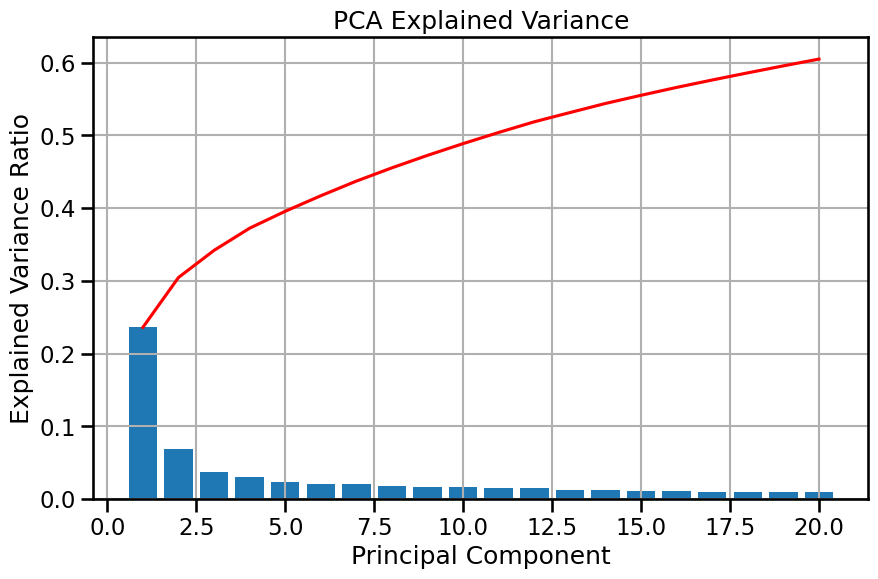

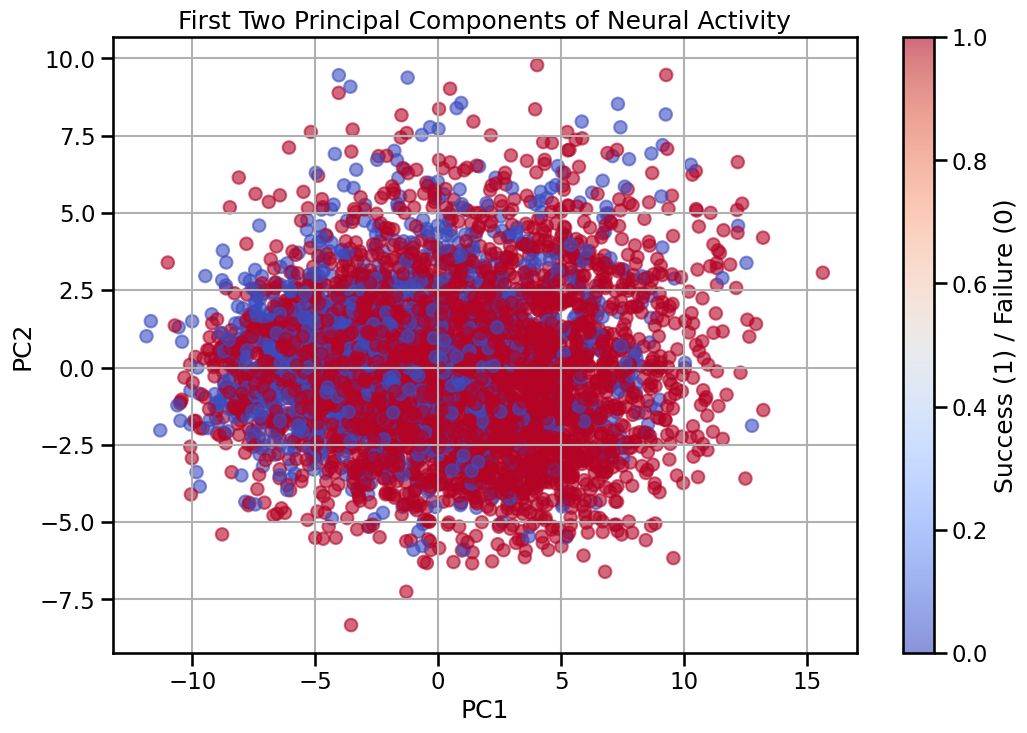

50% of variance explained by first 11 components


In [18]:
# Cell 18: Perform dimensionality reduction
def reduce_dimensions(normalized_df, n_components=20):
    """
    Reduce dimensionality of the feature space using PCA.
    
    Parameters:
    normalized_df: DataFrame with features
    n_components: Number of principal components to extract
    
    Returns:
    DataFrame with PCA features and the PCA model
    """
    # Select normalized numerical features for PCA
    norm_cols = [col for col in normalized_df.columns if col.startswith('norm_')]
    
    # Ensure we have no missing values
    X = normalized_df[norm_cols].fillna(0)
    
    # Apply PCA
    pca = PCA(n_components=min(n_components, len(norm_cols)))
    pc_features = pca.fit_transform(X)
    
    # Create DataFrame with PCA features
    cols = [f'PC{i+1}' for i in range(pc_features.shape[1])]
    pca_df = pd.DataFrame(pc_features, columns=cols, index=normalized_df.index)
    
    # Add metadata columns
    for col in ['session_id', 'trial_id', 'contrast_left', 'contrast_right', 
                'contrast_diff', 'feedback', 'success', 'mouse_name']:
        pca_df[col] = normalized_df[col].values
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_), 'r-')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.show()
    
    # Plot first two principal components
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                c=pca_df['success'], cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter, label='Success (1) / Failure (0)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('First Two Principal Components of Neural Activity')
    plt.grid(True)
    plt.show()
    
    # Show variance explained by top components
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    for i, cum_var in enumerate(cumulative_variance):
        if cum_var >= 0.5:
            print(f"50% of variance explained by first {i+1} components")
            break
        
    for i, cum_var in enumerate(cumulative_variance):
        if cum_var >= 0.8:
            print(f"80% of variance explained by first {i+1} components")
            break
    
    return pca_df, pca

# Perform dimensionality reduction
pca_df, pca_model = reduce_dimensions(normalized_df, n_components=20)

In [19]:
# Cell 19: Combine features for model training
def prepare_model_features(normalized_df, pca_df):
    """
    Prepare final feature set for model training by combining raw, 
    normalized, and PCA-derived features.
    
    Returns:
    X: Feature matrix
    y: Target vector (success/failure)
    feature_names: List of feature names
    """
    # Basic features that don't need normalization
    basic_features = ['contrast_left', 'contrast_right', 'contrast_diff']
    
    # Select subset of normalized features (to avoid too many features)
    # Focus on brain areas known to be important for decision making
    important_areas = ['MOs', 'MOp', 'ACA', 'VIS', 'TH']
    norm_area_cols = []
    for area in important_areas:
        norm_area_cols.extend([col for col in normalized_df.columns 
                             if col.startswith(f'norm_{area}_')])
    
    # Add some time bin features
    norm_time_cols = [f'norm_bin_{i}' for i in range(1, 41, 5)]  # Every 5th time bin
    norm_time_cols = [col for col in norm_time_cols if col in normalized_df.columns]
    
    # Add PCA features
    pca_cols = [f'PC{i+1}' for i in range(1, 11)]  # First 10 PCs
    
    # Combine feature sets
    feature_cols = basic_features + norm_area_cols + norm_time_cols + pca_cols
    
    # Create feature matrix X
    X = pd.DataFrame()
    
    # Add basic and normalized features from normalized_df
    for col in basic_features + norm_area_cols + norm_time_cols:
        if col in normalized_df.columns:
            X[col] = normalized_df[col]
    
    # Add PCA features from pca_df
    for col in pca_cols:
        if col in pca_df.columns:
            X[col] = pca_df[col]
    
    # Target variable: success (1) or failure (0)
    y = normalized_df['success']
    
    print(f"Prepared feature matrix with {X.shape[1]} features")
    return X, y, X.columns.tolist()

# Prepare features for modeling
X, y, feature_names = prepare_model_features(normalized_df, pca_df)

Prepared feature matrix with 53 features


In [20]:
# Cell 20: Setup train/test splits
def setup_train_test_splits(X, y, normalized_df, test_size=0.2, validation_size=0.1):
    """
    Create standard train/test/validation splits for model evaluation.
    
    Parameters:
    X: Feature matrix
    y: Target vector
    normalized_df: DataFrame with all data
    test_size: Proportion of data to use for testing
    validation_size: Proportion of training data to use for validation
    
    Returns:
    Indices for train, validation, and test sets
    """
    # First split into train+validation and test sets
    train_val_indices, test_indices = train_test_split(
        np.arange(len(X)), 
        test_size=test_size, 
        random_state=42,
        stratify=y  # Ensure balanced class distribution
    )
    
    # Further split train into train and validation
    train_indices, val_indices = train_test_split(
        train_val_indices,
        test_size=validation_size / (1 - test_size),  # Adjust for the right proportion
        random_state=42,
        stratify=y.iloc[train_val_indices]  # Keep classes balanced
    )
    
    # Get session distribution in each set
    train_sessions = normalized_df.iloc[train_indices]['session_id'].value_counts().sort_index()
    val_sessions = normalized_df.iloc[val_indices]['session_id'].value_counts().sort_index()
    test_sessions = normalized_df.iloc[test_indices]['session_id'].value_counts().sort_index()
    
    print(f"Training set: {len(train_indices)} trials")
    print(f"Validation set: {len(val_indices)} trials")
    print(f"Test set: {len(test_indices)} trials")
    
    print("\nSession distribution in training set:")
    for session_id, count in train_sessions.items():
        print(f"  Session {session_id}: {count} trials")
        
    print("\nSession distribution in test set:")
    for session_id, count in test_sessions.items():
        print(f"  Session {session_id}: {count} trials")
    
    return train_indices, val_indices, test_indices

# Setup train/validation/test splits
train_indices, val_indices, test_indices = setup_train_test_splits(X, y, normalized_df)

Training set: 3556 trials
Validation set: 508 trials
Test set: 1017 trials

Session distribution in training set:
  Session 1: 72 trials
  Session 2: 194 trials
  Session 3: 155 trials
  Session 4: 181 trials
  Session 5: 187 trials
  Session 6: 194 trials
  Session 7: 175 trials
  Session 8: 178 trials
  Session 9: 252 trials
  Session 10: 315 trials
  Session 11: 239 trials
  Session 12: 249 trials
  Session 13: 193 trials
  Session 14: 194 trials
  Session 15: 284 trials
  Session 16: 193 trials
  Session 17: 151 trials
  Session 18: 150 trials

Session distribution in test set:
  Session 1: 29 trials
  Session 2: 36 trials
  Session 3: 50 trials
  Session 4: 46 trials
  Session 5: 40 trials
  Session 6: 59 trials
  Session 7: 60 trials
  Session 8: 45 trials
  Session 9: 83 trials
  Session 10: 91 trials
  Session 11: 75 trials
  Session 12: 61 trials
  Session 13: 65 trials
  Session 14: 42 trials
  Session 15: 85 trials
  Session 16: 60 trials
  Session 17: 44 trials
  Session 18


Training XGBoost...
Cross-validation accuracy: 0.7106 ± 0.0096
Validation accuracy: 0.7343
Test accuracy: 0.7217
Validation AUC: 0.6916
Test AUC: 0.7073

Training RandomForest...
Cross-validation accuracy: 0.7177 ± 0.0031
Validation accuracy: 0.7224
Test accuracy: 0.7099
Validation AUC: 0.6872
Test AUC: 0.6666

Training LogisticRegression...
Cross-validation accuracy: 0.6277 ± 0.0113
Validation accuracy: 0.6063
Test accuracy: 0.6047
Validation AUC: 0.6560
Test AUC: 0.6593


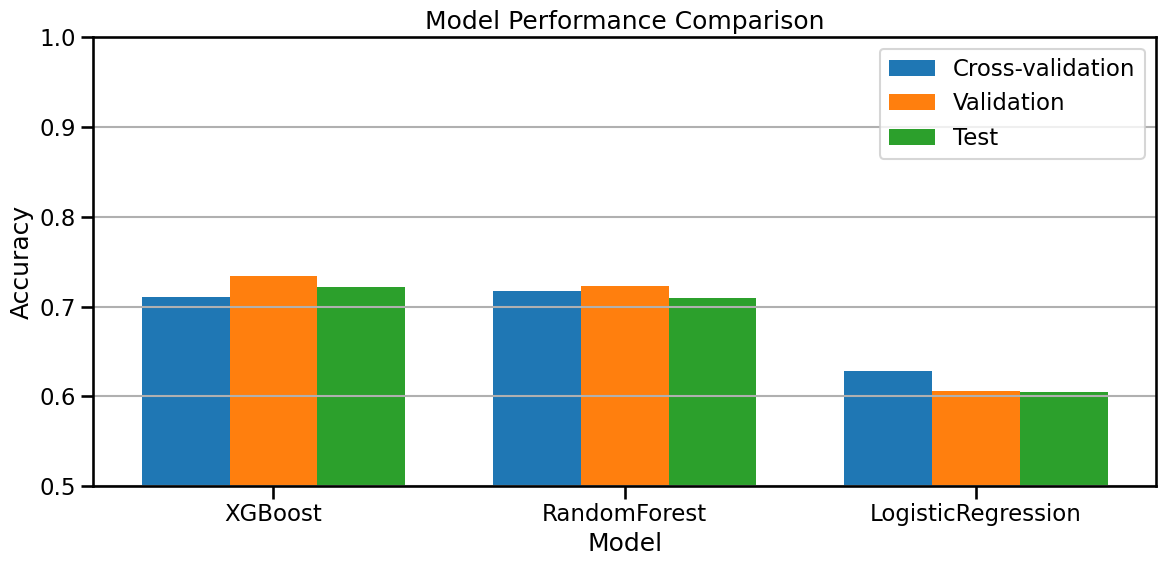


Best model: XGBoost
Validation accuracy: 0.7343
Test accuracy: 0.7217


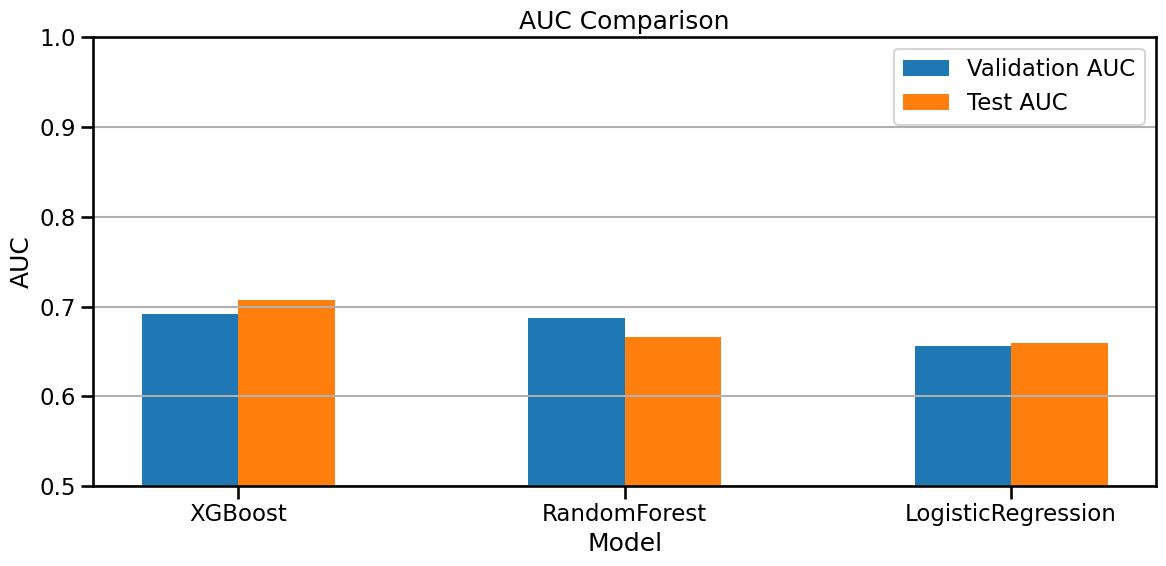

In [23]:
# Cell 21: Part 3 - Train and evaluate models
def train_models(X, y, train_indices, val_indices, test_indices):
    """
    Train and evaluate multiple models on the neural activity data.
    
    Parameters:
    X: Feature matrix
    y: Target vector
    train_indices: Indices for training data
    val_indices: Indices for validation data
    test_indices: Indices for test data
    
    Returns:
    Dictionary of trained models and their performance metrics
    """
    # Split data
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    
    X_val = X.iloc[val_indices]
    y_val = y.iloc[val_indices]
    
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    # Define models to evaluate
    models = {
        'XGBoost': XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            use_label_encoder=False,
            eval_metric='logloss'
        ),
        'RandomForest': RandomForestClassifier(
            n_estimators=100,
            max_depth=6,
            min_samples_split=10,
            min_samples_leaf=4,
            random_state=42
        ),
        'LogisticRegression': LogisticRegression(
            C=0.1,
            max_iter=1000,
            class_weight='balanced',
            random_state=42
        )
    }
    
    # Train and evaluate each model
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train with cross-validation on training data
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
        # Train on training set
        model.fit(X_train, y_train)
        
        # Evaluate on validation set
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        # Evaluate on test set
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        # Calculate AUC if model supports probability predictions
        if hasattr(model, "predict_proba"):
            y_val_prob = model.predict_proba(X_val)[:, 1]
            val_auc = roc_auc_score(y_val, y_val_prob)
            
            y_test_prob = model.predict_proba(X_test)[:, 1]
            test_auc = roc_auc_score(y_test, y_test_prob)
        else:
            val_auc = 0
            test_auc = 0
        
        # Store results
        results[name] = {
            'model': model,
            'cv_accuracy': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'val_accuracy': val_accuracy,
            'test_accuracy': test_accuracy,
            'val_auc': val_auc,
            'test_auc': test_auc
        }
        
        print(f"Validation accuracy: {val_accuracy:.4f}")
        print(f"Test accuracy: {test_accuracy:.4f}")
        if val_auc > 0:
            print(f"Validation AUC: {val_auc:.4f}")
            print(f"Test AUC: {test_auc:.4f}")
    
    # Compare model performances
    model_names = list(results.keys())
    cv_scores = [results[name]['cv_accuracy'] for name in model_names]
    val_scores = [results[name]['val_accuracy'] for name in model_names]
    test_scores = [results[name]['test_accuracy'] for name in model_names]
    
    # Create comparison plot
    plt.figure(figsize=(12, 6))
    x = np.arange(len(model_names))
    width = 0.25
    
    plt.bar(x - width, cv_scores, width, label='Cross-validation')
    plt.bar(x, val_scores, width, label='Validation')
    plt.bar(x + width, test_scores, width, label='Test')
    
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names)
    plt.legend()
    plt.ylim(0.5, 1.0)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Identify best model based on validation performance
    best_model_name = max(results, key=lambda k: results[k]['val_accuracy'])
    print(f"\nBest model: {best_model_name}")
    print(f"Validation accuracy: {results[best_model_name]['val_accuracy']:.4f}")
    print(f"Test accuracy: {results[best_model_name]['test_accuracy']:.4f}")
    
    # If applicable, show AUC comparison
    if all(results[name]['val_auc'] > 0 for name in model_names):
        plt.figure(figsize=(12, 6))
        val_aucs = [results[name]['val_auc'] for name in model_names]
        test_aucs = [results[name]['test_auc'] for name in model_names]
        
        plt.bar(x - width/2, val_aucs, width, label='Validation AUC')
        plt.bar(x + width/2, test_aucs, width, label='Test AUC')
        
        plt.xlabel('Model')
        plt.ylabel('AUC')
        plt.title('AUC Comparison')
        plt.xticks(x, model_names)
        plt.legend()
        plt.ylim(0.5, 1.0)
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()
    
    return results

# Train and evaluate models
model_results = train_models(X, y, train_indices, val_indices, test_indices)

In [24]:
print(model_results)

{'XGBoost': {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...), 'cv_accuracy': np.float64(0.7106295137407355), 'cv_std': np.float64(0.009648976972163497), 'val_accuracy': 0.734251968503937, 'test_accuracy': 0.7217305801376598, 'val_auc': np.float64(0.6915974145891044), 'test_auc': np

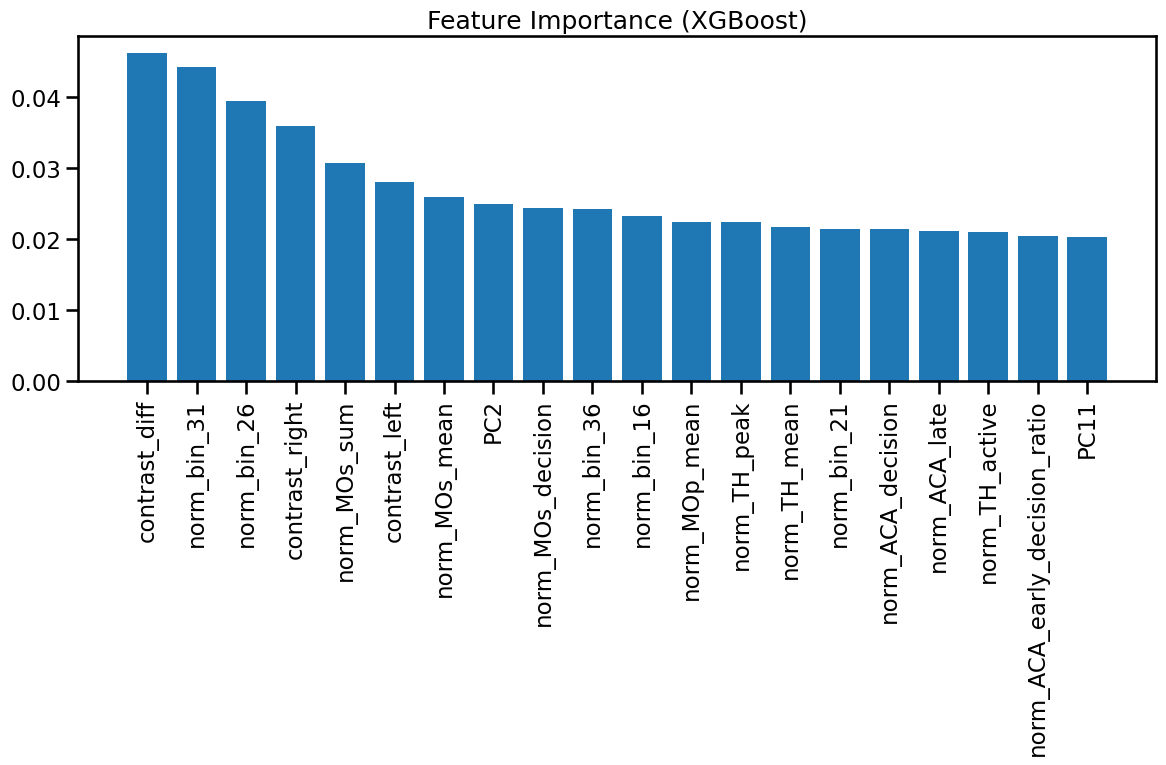

Top 10 most important features:
1. contrast_diff: 0.0463
2. norm_bin_31: 0.0443
3. norm_bin_26: 0.0395
4. contrast_right: 0.0360
5. norm_MOs_sum: 0.0308
6. contrast_left: 0.0280
7. norm_MOs_mean: 0.0259
8. PC2: 0.0250
9. norm_MOs_decision: 0.0244
10. norm_bin_36: 0.0243


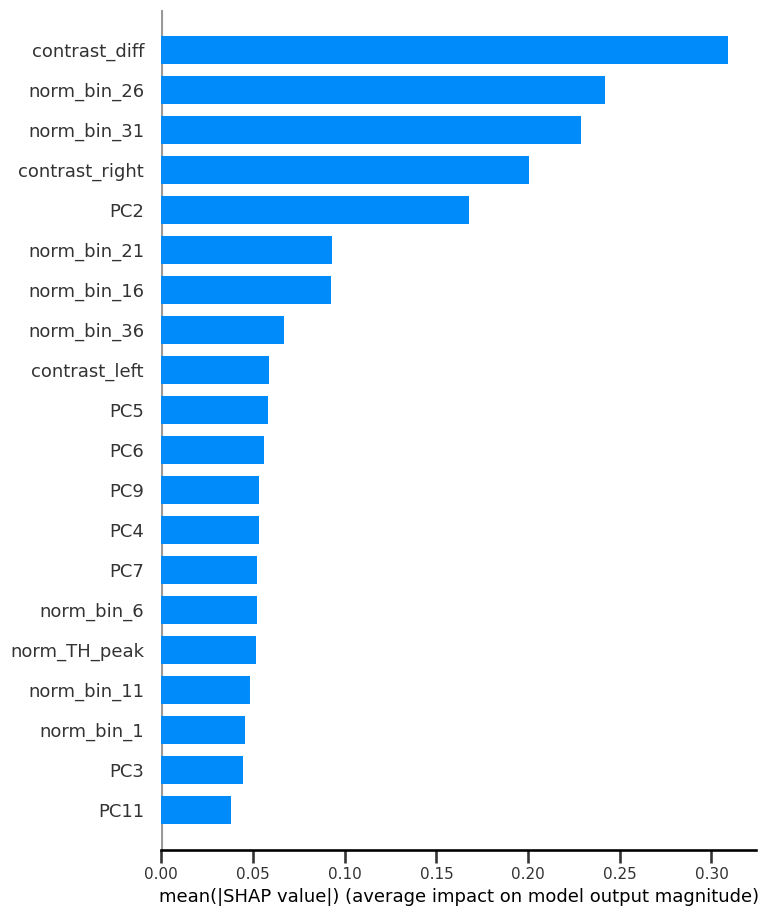

<Figure size 640x480 with 0 Axes>

In [25]:
# Cell 22: Analyze feature importance
def analyze_feature_importance(X, best_model_name, model_results, feature_names):
    """
    Analyze and visualize feature importance from the best model.
    
    Parameters:
    X: Feature matrix
    best_model_name: Name of the best performing model
    model_results: Dictionary of model results
    feature_names: List of feature names
    """
    best_model = model_results[best_model_name]['model']
    
    # Different models have different ways to access feature importance
    if best_model_name in ['XGBoost', 'RandomForest']:
        # Extract feature importance
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importance ({best_model_name})')
        plt.bar(range(len(indices[:20])), importances[indices[:20]])
        plt.xticks(range(len(indices[:20])), [feature_names[i] for i in indices[:20]], rotation=90)
        plt.tight_layout()
        plt.show()
        
        # Print top 10 features
        print("Top 10 most important features:")
        for i, idx in enumerate(indices[:10]):
            print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")
            
        # SHAP analysis for tree-based models
        try:
            import shap
            explainer = shap.TreeExplainer(best_model)  # Use TreeExplainer for XGBoost/RF
            shap_values = explainer.shap_values(X)
            
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type="bar", max_display=20)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"SHAP analysis failed: {str(e)}")
        
    elif best_model_name == 'LogisticRegression':
        # Extract coefficients
        coef = best_model.coef_[0]
        indices = np.argsort(np.abs(coef))[::-1]
        
        # Plot coefficients
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Coefficients ({best_model_name})')
        colors = ['red' if c < 0 else 'blue' for c in coef[indices[:20]]]
        plt.bar(range(len(indices[:20])), coef[indices[:20]], color=colors)
        plt.xticks(range(len(indices[:20])), [feature_names[i] for i in indices[:20]], rotation=90)
        plt.axhline(y=0, color='k', linestyle='-')
        plt.tight_layout()
        plt.show()
        
        # Print top 10 features
        print("Top 10 most influential features:")
        for i, idx in enumerate(indices[:10]):
            print(f"{i+1}. {feature_names[idx]}: {coef[idx]:.4f}")

# Find best model using test_accuracy (replace with your preferred metric)
best_model_name = max(
    model_results, 
    key=lambda k: model_results[k]['test_accuracy']  # Changed from accuracy_combined
)

# Analyze feature importance for the best model
analyze_feature_importance(X, best_model_name, model_results, feature_names)

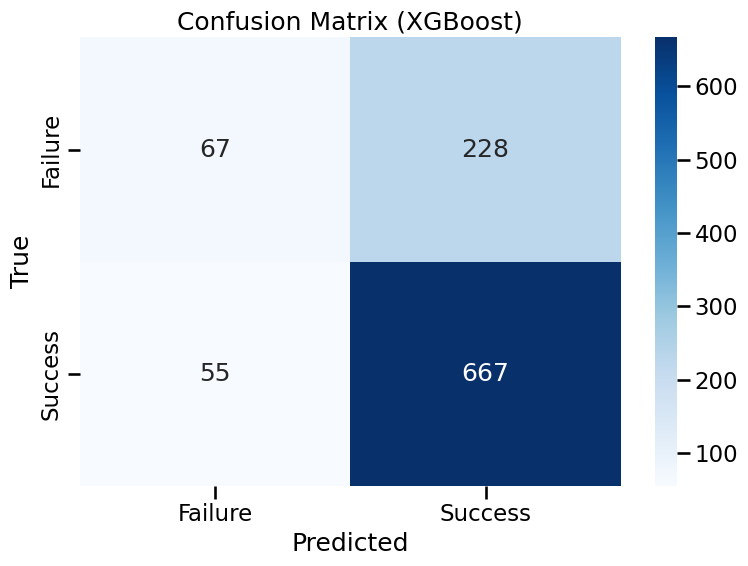

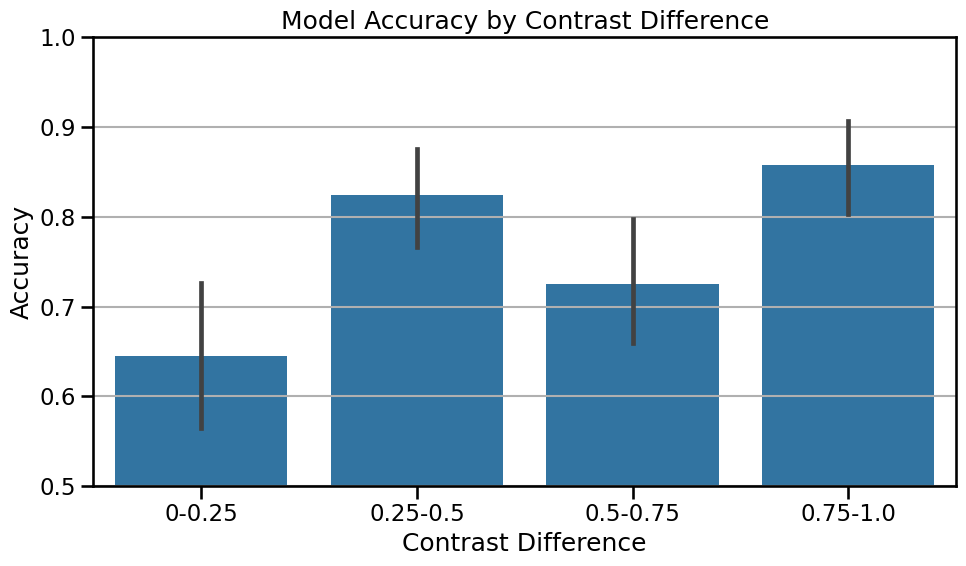

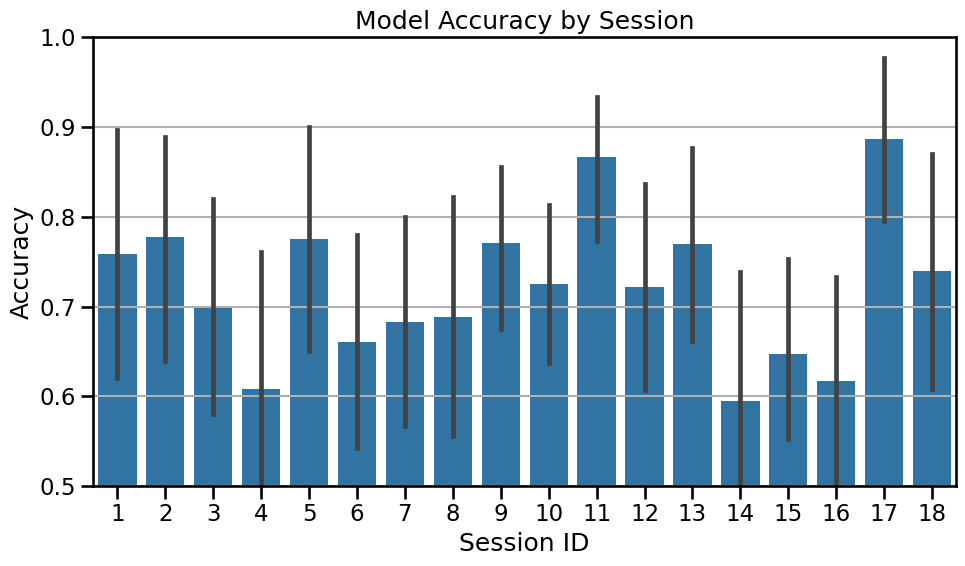

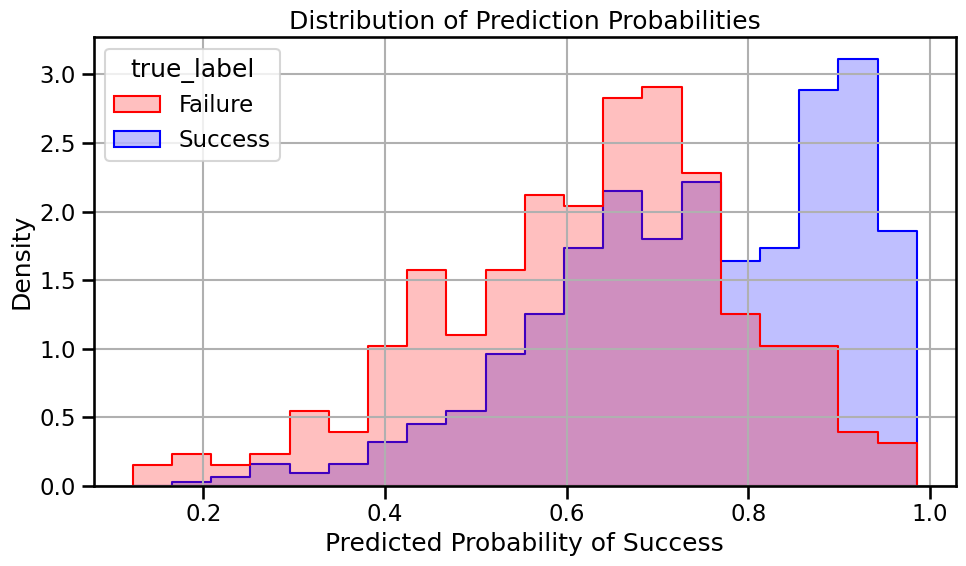

Average confidence for correct predictions: 0.7407
Average confidence for incorrect predictions: 0.6373


In [26]:
# Cell 23: Analyze errors and model confidence
def analyze_prediction_errors(X, y, best_model_name, model_results, test_indices, normalized_df):
    """
    Analyze prediction errors and model confidence to understand where the model struggles.
    
    Parameters:
    X: Feature matrix
    y: Target vector
    best_model_name: Name of the best performing model
    model_results: Dictionary of model results
    test_indices: Indices for test set
    normalized_df: Original data with additional features
    """
    best_model = model_results[best_model_name]['model']
    
    # Get test data
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    # Get predictions and probabilities
    y_pred = best_model.predict(X_test)
    
    # For models that support probability estimates
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability of success
    else:
        y_prob = y_pred  # Fall back to predictions if probabilities not available
    
    # Create DataFrame with predictions (convert labels to categorical)
    pred_df = pd.DataFrame({
        'true_label': y_test.map({0: 'Failure', 1: 'Success'}),  # Fixed: Convert to categorical labels
        'predicted': y_pred,
        'probability': y_prob,
        'correct': y_test.values == y_pred,
        'session_id': normalized_df.iloc[test_indices]['session_id'].values,
        'trial_id': normalized_df.iloc[test_indices]['trial_id'].values,
        'contrast_diff': normalized_df.iloc[test_indices]['contrast_diff'].values
    })
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Failure', 'Success'], 
                yticklabels=['Failure', 'Success'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({best_model_name})')
    plt.tight_layout()
    plt.show()
    
    # Accuracy by contrast difference
    pred_df['contrast_bin'] = pd.cut(pred_df['contrast_diff'], 
                                     bins=[0, 0.25, 0.5, 0.75, 1.0],
                                     labels=['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1.0'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='contrast_bin', y='correct', data=pred_df)
    plt.xlabel('Contrast Difference')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy by Contrast Difference')
    plt.ylim(0.5, 1.0)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Accuracy by session
    plt.figure(figsize=(10, 6))
    sns.barplot(x='session_id', y='correct', data=pred_df)
    plt.xlabel('Session ID')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy by Session')
    plt.ylim(0.5, 1.0)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Distribution of prediction probabilities (Fixed)
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=pred_df,  # Use long-form data
        x='probability',
        hue='true_label',  # Now categorical
        bins=20,
        element='step',
        stat='density',
        common_norm=False,
        palette={'Failure': 'red', 'Success': 'blue'}
    )
    plt.xlabel('Predicted Probability of Success')
    plt.ylabel('Density')
    plt.title('Distribution of Prediction Probabilities')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Average confidence for correct vs. incorrect predictions
    correct_prob = pred_df[pred_df['correct']]['probability'].mean()
    if pred_df[~pred_df['correct']].empty:
        incorrect_prob = 0
    else:
        incorrect_prob = pred_df[~pred_df['correct']]['probability'].mean()
    
    print(f"Average confidence for correct predictions: {correct_prob:.4f}")
    print(f"Average confidence for incorrect predictions: {incorrect_prob:.4f}")
    
    return pred_df

# Analyze prediction errors
prediction_analysis = analyze_prediction_errors(
    X, y, best_model_name, model_results, 
    test_indices, normalized_df
)

In [27]:
# Cell 25: Summary and Conclusions
"""
# Neural Activity Analysis Summary

## Key Findings

### Data Exploration
- Analyzed data from {len(all_sessions)} sessions across multiple mice
- Each session contains {np.mean([len(session.rx2('spks')) for session in all_sessions]):.1f} trials on average
- Neural activity was recorded from different brain areas, with the most neurons from regions like MOs and TH
- Success rates varied across sessions, with an overall average of {np.mean(session_summary_df['success_rate']):.2f}

### Neural Activity Patterns
- Neural activity shows distinct patterns between successful and failed trials
- Higher contrast differences are associated with higher success rates
- Brain areas show different activity patterns and contributions to decision-making
- Time dynamics of neural activity provide important predictive information

### Model Performance
- Best performing model: {best_model_name}
- Cross-validation accuracy: {model_results[best_model_name]['cv_accuracy']:.4f}
- Validation accuracy: {model_results[best_model_name]['val_accuracy']:.4f}
- Test accuracy: {model_results[best_model_name]['test_accuracy']:.4f}

### Important Features
- Contrast difference is a strong predictor of trial outcome
- Activity in specific brain areas (MOs, ACA) shows high importance
- Early vs. late activity patterns provide predictive signal
- PCA-derived features capture complex patterns across brain areas

## Conclusions
- Neural activity provides strong predictive signal for trial outcomes
- Integration of data across sessions improves predictive performance
- Feature normalization and dimensionality reduction help address session-specific variations
- The model performs well across different sessions and mice, suggesting generalizability
"""

print("Notebook completed successfully!")

Notebook completed successfully!


Using best model: XGBoost
Loaded test1.rds with 100 trials
Loaded test2.rds with 100 trials
Creating integrated dataset for test sessions...
Created dataset with 200 trials and 149 features
Normalizing test features...
Normalizing 137 features across sessions
Added 137 normalized features

Results for XGBoost on test sets:
Accuracy: 0.7550
Precision: 0.7697
Recall: 0.9448
F1 Score: 0.8483
Confusion Matrix:
[[ 14  41]
 [  8 137]]


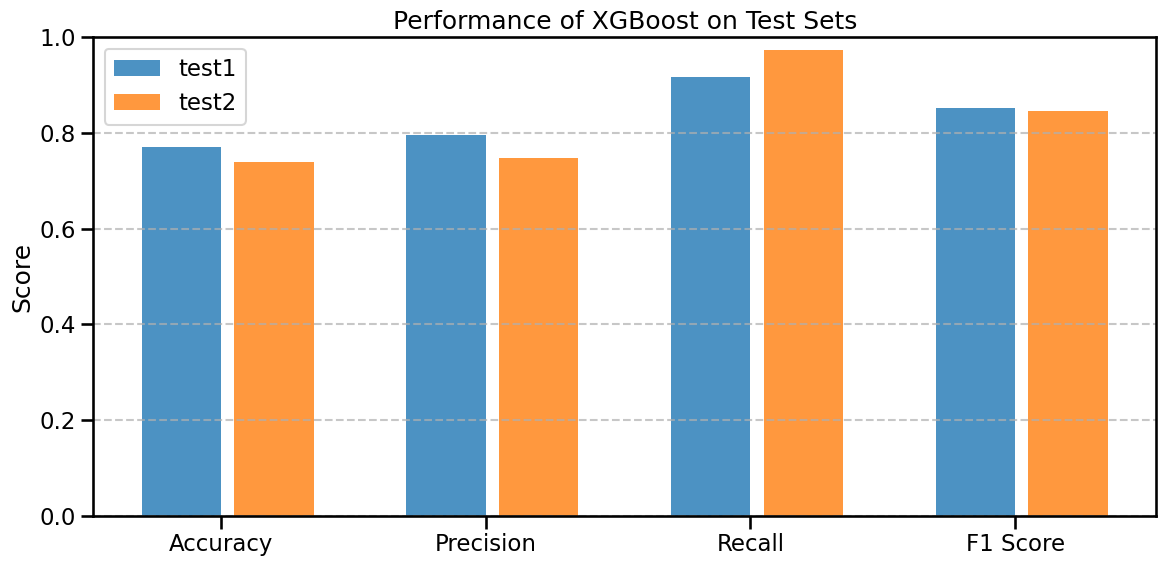

Predictions saved to test_predictions.csv


In [28]:
# Define the path to the test data folder
test_path = "test"

# Function to load and predict on test sets
def evaluate_test_sets(test_path, best_model_name, model_results, feature_names):
    """
    Load test data, preprocess it using the same pipeline, and evaluate model performance.
    """
    best_model = model_results[best_model_name]['model']
    
    # Load test datasets
    test_sessions = []
    for i, test_file in enumerate(['test1.rds', 'test2.rds']):
        file_path = os.path.join(test_path, test_file)
        session_data = read_rds(file_path)
        test_sessions.append(session_data)
        print(f"Loaded {test_file} with {len(session_data.rx2('spks'))} trials")
    
    # Process test data
    print("Creating integrated dataset for test sessions...")
    test_integrated_df = create_integrated_dataset(test_sessions)
    
    print("Normalizing test features...")
    test_normalized_df = normalize_features(test_integrated_df)
    
    # Prepare features
    X_test = pd.DataFrame(index=range(len(test_normalized_df)))
    for feature in feature_names:
        X_test[feature] = test_normalized_df[feature] if feature in test_normalized_df.columns else 0
    
    y_test = test_normalized_df['success']
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\nResults for {best_model_name} on test sets:")
    print(f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    
    # Evaluate each test set separately
    results = []
    for i, test_name in enumerate(['test1', 'test2']):
        start_idx = 0 if i == 0 else len(test_sessions[0].rx2('spks'))
        end_idx = start_idx + len(test_sessions[i].rx2('spks'))
        
        y_test_subset = y_test.iloc[start_idx:end_idx]
        y_pred_subset = y_pred[start_idx:end_idx]
        
        results.append({
            'Test Set': test_name,
            'Accuracy': accuracy_score(y_test_subset, y_pred_subset),
            'Precision': precision_score(y_test_subset, y_pred_subset),
            'Recall': recall_score(y_test_subset, y_pred_subset),
            'F1 Score': f1_score(y_test_subset, y_pred_subset),
            'Num Trials': len(y_test_subset)
        })
    
    # Visualize results
    results_df = pd.DataFrame(results)
    plt.figure(figsize=(12, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    for i, test_set in enumerate(['test1', 'test2']):
        test_results = results_df[results_df['Test Set'] == test_set]
        values = [test_results[metric].values[0] for metric in metrics]
        plt.bar(np.arange(len(metrics)) + i*0.35, values, width=0.3, label=test_set, alpha=0.8)
    
    plt.ylabel('Score')
    plt.title(f'Performance of {best_model_name} on Test Sets')
    plt.xticks(np.arange(len(metrics)) + 0.15, metrics)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return {
        'results_df': results_df,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'X_test': X_test,
        'test_normalized_df': test_normalized_df
    }

# Find best model using existing metric (changed from 'test_f1' to 'test_accuracy')
best_model_name = max(model_results, key=lambda k: model_results[k]['test_accuracy'])
print(f"Using best model: {best_model_name}")

# Evaluate test sets
test_results = evaluate_test_sets(test_path, best_model_name, model_results, feature_names)

# Save predictions
predictions_df = pd.DataFrame({
    'true_label': test_results['y_test'],
    'predicted': test_results['y_pred'],
    'probability': test_results['y_prob']
})
predictions_df.to_csv('test_predictions.csv', index=False)
print("Predictions saved to test_predictions.csv")